# Imports

In [70]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import numpy as np
%matplotlib inline

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc

In [164]:
from catboost import CatBoostClassifier
from catboost import Pool, cv
import optuna
import pandas_profiling as pp

# Load Data

In [7]:
train = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')

In [8]:
labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

In [9]:
num_cols = train.select_dtypes('number').columns

In [10]:
cat_cols = ['race', 'sex', 'marital_status', 'rent_or_own',  'hhs_geo_region','census_msa', 'employment_industry', 'employment_occupation']

In [11]:
ord_cols = ['age_group', 'education',  'income_poverty','employment_status']

# Cleaning Data

In [12]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [13]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [17]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [18]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

# Train Test Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.3, random_state=10)

# Optuna Optimization with Cross Validation

In [61]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34], dtype=int64)

In [62]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

### H1N1 Vaccine

In [114]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength':trial.suggest_int('random_strength', 1,10),
        'bagging_temperature':trial.suggest_int('bagging_temperature', 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree']),
        'od_type' : "Iter",
        'od_wait' : 100,
        'depth': trial.suggest_int('max_depth', 2,10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        'loss_function': 'Logloss',
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [117]:
sampler = optuna.samplers.TPESampler(seed=68)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-01-26 23:51:35,013] A new study created in memory with name: no-name-679d1a3b-561c-49ba-b88e-3c77b018b5c1


Training on fold [0/5]

bestTest = 0.4800267194
bestIteration = 138

Training on fold [1/5]

bestTest = 0.4803565075
bestIteration = 88

Training on fold [2/5]

bestTest = 0.4557125946
bestIteration = 165

Training on fold [3/5]

bestTest = 0.4558662431
bestIteration = 142

Training on fold [4/5]


[I 2022-01-26 23:52:12,942] Trial 0 finished with value: 0.859674522897232 and parameters: {'iterations': 1500, 'learning_rate': 0.08961999953042239, 'random_strength': 9, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0011812125446097113, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.859674522897232.



bestTest = 0.4685838925
bestIteration = 156

Training on fold [0/5]

bestTest = 0.471572776
bestIteration = 87

Training on fold [1/5]

bestTest = 0.466209224
bestIteration = 101

Training on fold [2/5]

bestTest = 0.4580139837
bestIteration = 90

Training on fold [3/5]

bestTest = 0.4461810667
bestIteration = 96

Training on fold [4/5]


[I 2022-01-26 23:52:15,345] Trial 1 finished with value: 0.863289970742208 and parameters: {'iterations': 1000, 'learning_rate': 0.2957047309441607, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.001354720669824658, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.863289970742208.



bestTest = 0.4605350918
bestIteration = 91

Training on fold [0/5]

bestTest = 0.4715355548
bestIteration = 168

Training on fold [1/5]

bestTest = 0.4676619506
bestIteration = 196

Training on fold [2/5]

bestTest = 0.4542013256
bestIteration = 231

Training on fold [3/5]

bestTest = 0.4486095209
bestIteration = 182

Training on fold [4/5]


[I 2022-01-26 23:52:19,844] Trial 2 finished with value: 0.8632956759850922 and parameters: {'iterations': 1200, 'learning_rate': 0.1371525795360902, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.0048185425547954824, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8632956759850922.



bestTest = 0.4648767151
bestIteration = 153

Training on fold [0/5]

bestTest = 0.5016222563
bestIteration = 156

Training on fold [1/5]

bestTest = 0.4997414344
bestIteration = 130

Training on fold [2/5]

bestTest = 0.4939671192
bestIteration = 132

Training on fold [3/5]

bestTest = 0.48390452
bestIteration = 146

Training on fold [4/5]


[I 2022-01-26 23:53:14,916] Trial 3 finished with value: 0.8442722380592821 and parameters: {'iterations': 300, 'learning_rate': 0.026623822549052163, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 1.9008463722440555e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8632956759850922.



bestTest = 0.5044996904
bestIteration = 100

Training on fold [0/5]

bestTest = 0.4811616152
bestIteration = 995

Training on fold [1/5]

bestTest = 0.4779160529
bestIteration = 960

Training on fold [2/5]

bestTest = 0.4654556267
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4572221802
bestIteration = 997

Training on fold [4/5]


[I 2022-01-26 23:53:50,148] Trial 4 finished with value: 0.8603224232889767 and parameters: {'iterations': 1000, 'learning_rate': 0.007101034052723374, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.005827202489296445, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8632956759850922.



bestTest = 0.468480216
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4713926445
bestIteration = 91

Training on fold [1/5]

bestTest = 0.4630923856
bestIteration = 141

Training on fold [2/5]

bestTest = 0.4526810883
bestIteration = 123

Training on fold [3/5]

bestTest = 0.4502733145
bestIteration = 65

Training on fold [4/5]


[I 2022-01-26 23:53:53,003] Trial 5 finished with value: 0.8632519878692669 and parameters: {'iterations': 1500, 'learning_rate': 0.2964430813582234, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 1.7622702261668875e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8632956759850922.



bestTest = 0.4618003787
bestIteration = 83

Training on fold [0/5]

bestTest = 0.4676575901
bestIteration = 67

Training on fold [1/5]

bestTest = 0.465812894
bestIteration = 57

Training on fold [2/5]

bestTest = 0.4473531453
bestIteration = 79

Training on fold [3/5]

bestTest = 0.4382620002
bestIteration = 85

Training on fold [4/5]


[I 2022-01-26 23:54:16,820] Trial 6 finished with value: 0.867348172022281 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 23.41661191676168, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.867348172022281.



bestTest = 0.4524437104
bestIteration = 88

Training on fold [0/5]

bestTest = 0.5501944566
bestIteration = 11

Training on fold [1/5]

bestTest = 0.5406959924
bestIteration = 21

Training on fold [2/5]

bestTest = 0.5285141666
bestIteration = 15

Training on fold [3/5]

bestTest = 0.5065933923
bestIteration = 19

Training on fold [4/5]


[I 2022-01-26 23:54:19,400] Trial 7 finished with value: 0.8216979088544699 and parameters: {'iterations': 1500, 'learning_rate': 0.1253699635699981, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 2.8307160689696775e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.867348172022281.



bestTest = 0.5265408955
bestIteration = 13

Training on fold [0/5]

bestTest = 0.5034953617
bestIteration = 146

Training on fold [1/5]

bestTest = 0.5004125661
bestIteration = 129

Training on fold [2/5]

bestTest = 0.4835811153
bestIteration = 187

Training on fold [3/5]

bestTest = 0.4813393829
bestIteration = 168

Training on fold [4/5]


[I 2022-01-26 23:54:36,623] Trial 8 finished with value: 0.8498436346793505 and parameters: {'iterations': 1000, 'learning_rate': 0.00957473821190967, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0003332900472045444, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.867348172022281.



bestTest = 0.4860642251
bestIteration = 162

Training on fold [0/5]

bestTest = 0.537475882
bestIteration = 4

Training on fold [1/5]

bestTest = 0.5236289784
bestIteration = 4

Training on fold [2/5]

bestTest = 0.5352038461
bestIteration = 3

Training on fold [3/5]

bestTest = 0.5203430866
bestIteration = 6

Training on fold [4/5]


[I 2022-01-26 23:54:38,150] Trial 9 finished with value: 0.827011333664655 and parameters: {'iterations': 1000, 'learning_rate': 0.2301364835144914, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0013398579507442577, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.867348172022281.



bestTest = 0.5153978829
bestIteration = 6

Training on fold [0/5]

bestTest = 0.46363464
bestIteration = 100

Training on fold [1/5]

bestTest = 0.4652581738
bestIteration = 83

Training on fold [2/5]

bestTest = 0.4470167104
bestIteration = 114

Training on fold [3/5]

bestTest = 0.4376276767
bestIteration = 121

Training on fold [4/5]


[I 2022-01-26 23:54:57,035] Trial 10 finished with value: 0.8674106123410841 and parameters: {'iterations': 300, 'learning_rate': 0.21210578031115196, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 67.55513953843523, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8674106123410841.



bestTest = 0.4585905996
bestIteration = 90

Training on fold [0/5]

bestTest = 0.4637750331
bestIteration = 175

Training on fold [1/5]

bestTest = 0.4659120898
bestIteration = 90

Training on fold [2/5]

bestTest = 0.4462770785
bestIteration = 110

Training on fold [3/5]

bestTest = 0.4346071656
bestIteration = 144

Training on fold [4/5]


[I 2022-01-26 23:55:20,676] Trial 11 finished with value: 0.867960051987005 and parameters: {'iterations': 300, 'learning_rate': 0.21179272225527906, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 34.56103765349822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4577913998
bestIteration = 112

Training on fold [0/5]

bestTest = 0.4650659812
bestIteration = 144

Training on fold [1/5]

bestTest = 0.4662131978
bestIteration = 112

Training on fold [2/5]

bestTest = 0.4511952229
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4355559885
bestIteration = 131

Training on fold [4/5]


[I 2022-01-26 23:55:42,234] Trial 12 finished with value: 0.8668662876894737 and parameters: {'iterations': 300, 'learning_rate': 0.21371183387618528, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 95.0310408809215, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4576871031
bestIteration = 112

Training on fold [0/5]

bestTest = 0.4639874638
bestIteration = 108

Training on fold [1/5]

bestTest = 0.4689434821
bestIteration = 77

Training on fold [2/5]

bestTest = 0.4483762098
bestIteration = 118

Training on fold [3/5]

bestTest = 0.442906767
bestIteration = 101

Training on fold [4/5]


[I 2022-01-26 23:56:00,498] Trial 13 finished with value: 0.8655921647279602 and parameters: {'iterations': 500, 'learning_rate': 0.1836821261830615, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 1.293189787628666, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4622519583
bestIteration = 79

Training on fold [0/5]

bestTest = 0.4658527384
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4650350552
bestIteration = 113

Training on fold [2/5]

bestTest = 0.4470709225
bestIteration = 122

Training on fold [3/5]

bestTest = 0.4384258144
bestIteration = 135

Training on fold [4/5]


[I 2022-01-26 23:56:19,230] Trial 14 finished with value: 0.8669943879966576 and parameters: {'iterations': 300, 'learning_rate': 0.18241430488443391, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.6021265533288196, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4586302426
bestIteration = 94

Training on fold [0/5]

bestTest = 0.479887537
bestIteration = 32

Training on fold [1/5]

bestTest = 0.4785047375
bestIteration = 31

Training on fold [2/5]

bestTest = 0.463966688
bestIteration = 35

Training on fold [3/5]

bestTest = 0.4562164525
bestIteration = 28

Training on fold [4/5]


[I 2022-01-26 23:56:35,849] Trial 15 finished with value: 0.8586652640584596 and parameters: {'iterations': 300, 'learning_rate': 0.2549106738246301, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.8549315771643822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4649236262
bestIteration = 31

Training on fold [0/5]

bestTest = 0.46622272
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4690424527
bestIteration = 92

Training on fold [2/5]

bestTest = 0.4515788725
bestIteration = 88

Training on fold [3/5]

bestTest = 0.4414120433
bestIteration = 112

Training on fold [4/5]


[I 2022-01-26 23:57:00,500] Trial 16 finished with value: 0.8654367088660271 and parameters: {'iterations': 1200, 'learning_rate': 0.1773384227926434, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 7.995973902506912, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.458204169
bestIteration = 95

Training on fold [0/5]

bestTest = 0.4702420824
bestIteration = 58

Training on fold [1/5]

bestTest = 0.4670042477
bestIteration = 85

Training on fold [2/5]

bestTest = 0.4498976441
bestIteration = 89

Training on fold [3/5]

bestTest = 0.4449690167
bestIteration = 103

Training on fold [4/5]


[I 2022-01-26 23:57:11,458] Trial 17 finished with value: 0.8643413279432368 and parameters: {'iterations': 500, 'learning_rate': 0.25475797341100803, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.06306159710746394, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4604964384
bestIteration = 91

Training on fold [0/5]

bestTest = 0.4971344226
bestIteration = 53

Training on fold [1/5]

bestTest = 0.5035116352
bestIteration = 21

Training on fold [2/5]

bestTest = 0.4834361053
bestIteration = 37

Training on fold [3/5]

bestTest = 0.4842337446
bestIteration = 44

Training on fold [4/5]


[I 2022-01-26 23:57:14,200] Trial 18 finished with value: 0.8462466701753548 and parameters: {'iterations': 300, 'learning_rate': 0.08253977991457023, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.8479737297402608e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4843504744
bestIteration = 58

Training on fold [0/5]

bestTest = 0.4737875375
bestIteration = 41

Training on fold [1/5]

bestTest = 0.4721432524
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4496738577
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4360977162
bestIteration = 84

Training on fold [4/5]


[I 2022-01-26 23:57:31,588] Trial 19 finished with value: 0.8649588999181332 and parameters: {'iterations': 300, 'learning_rate': 0.1560323824455655, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 0.0856345075555827, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4611109304
bestIteration = 53

Training on fold [0/5]

bestTest = 0.4663968529
bestIteration = 93

Training on fold [1/5]

bestTest = 0.4659351425
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4510832329
bestIteration = 63

Training on fold [3/5]

bestTest = 0.4419513566
bestIteration = 96

Training on fold [4/5]


[I 2022-01-26 23:57:43,839] Trial 20 finished with value: 0.8659678174922438 and parameters: {'iterations': 300, 'learning_rate': 0.264209881402545, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 77.61336989410746, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4579689748
bestIteration = 105

Training on fold [0/5]

bestTest = 0.4785641579
bestIteration = 41

Training on fold [1/5]

bestTest = 0.4698544955
bestIteration = 52

Training on fold [2/5]

bestTest = 0.4508920577
bestIteration = 67

Training on fold [3/5]

bestTest = 0.4428345296
bestIteration = 63

Training on fold [4/5]


[I 2022-01-26 23:58:06,005] Trial 21 finished with value: 0.863406934532984 and parameters: {'iterations': 300, 'learning_rate': 0.21082492056123503, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 11.178248201032774, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4592847751
bestIteration = 67

Training on fold [0/5]

bestTest = 0.4637043983
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4653046749
bestIteration = 66

Training on fold [2/5]

bestTest = 0.4490854129
bestIteration = 93

Training on fold [3/5]

bestTest = 0.4379979197
bestIteration = 83

Training on fold [4/5]


[I 2022-01-26 23:58:24,662] Trial 22 finished with value: 0.8669982009037763 and parameters: {'iterations': 300, 'learning_rate': 0.22697725352490358, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 17.4112617465734, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4598277684
bestIteration = 70

Training on fold [0/5]

bestTest = 0.4724173939
bestIteration = 59

Training on fold [1/5]

bestTest = 0.4691326151
bestIteration = 55

Training on fold [2/5]

bestTest = 0.4533752945
bestIteration = 64

Training on fold [3/5]

bestTest = 0.4377204914
bestIteration = 70

Training on fold [4/5]


[I 2022-01-26 23:58:48,123] Trial 23 finished with value: 0.8645392856780658 and parameters: {'iterations': 300, 'learning_rate': 0.19981500032010918, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 3.7174919929890318, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.460813464
bestIteration = 67

Training on fold [0/5]

bestTest = 0.4681655409
bestIteration = 80

Training on fold [1/5]

bestTest = 0.4640281722
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4481196445
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4431376287
bestIteration = 78

Training on fold [4/5]


[I 2022-01-26 23:59:00,821] Trial 24 finished with value: 0.8661912941917554 and parameters: {'iterations': 500, 'learning_rate': 0.24565688129910673, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.1444419042507601, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4574062094
bestIteration = 163

Training on fold [0/5]

bestTest = 0.4678809451
bestIteration = 57

Training on fold [1/5]

bestTest = 0.4679127858
bestIteration = 56

Training on fold [2/5]

bestTest = 0.4468153613
bestIteration = 74

Training on fold [3/5]

bestTest = 0.4388436838
bestIteration = 88

Training on fold [4/5]


[I 2022-01-26 23:59:18,093] Trial 25 finished with value: 0.8659603661408593 and parameters: {'iterations': 1200, 'learning_rate': 0.27431952223791756, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 91.73489550576943, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4593276849
bestIteration = 79

Training on fold [0/5]

bestTest = 0.468695692
bestIteration = 72

Training on fold [1/5]

bestTest = 0.4646645434
bestIteration = 68

Training on fold [2/5]

bestTest = 0.4495941228
bestIteration = 68

Training on fold [3/5]

bestTest = 0.4415535944
bestIteration = 78

Training on fold [4/5]


[I 2022-01-26 23:59:43,722] Trial 26 finished with value: 0.8655372165904207 and parameters: {'iterations': 300, 'learning_rate': 0.2031896271857559, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 24.1680862544522, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4619253331
bestIteration = 72

Training on fold [0/5]

bestTest = 0.466024284
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4689380367
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4504688586
bestIteration = 84

Training on fold [3/5]

bestTest = 0.4415545331
bestIteration = 83

Training on fold [4/5]


[I 2022-01-27 00:00:08,413] Trial 27 finished with value: 0.8657309561373261 and parameters: {'iterations': 300, 'learning_rate': 0.15720264436462683, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 2.5669558901552656, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4591635148
bestIteration = 85

Training on fold [0/5]

bestTest = 0.4803977067
bestIteration = 52

Training on fold [1/5]

bestTest = 0.4739775597
bestIteration = 58

Training on fold [2/5]

bestTest = 0.4584491261
bestIteration = 50

Training on fold [3/5]

bestTest = 0.4475288338
bestIteration = 57

Training on fold [4/5]


[I 2022-01-27 00:00:10,338] Trial 28 finished with value: 0.8615255859518017 and parameters: {'iterations': 300, 'learning_rate': 0.23512416914721398, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 1.0595003544247859e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4661947025
bestIteration = 52

Training on fold [0/5]

bestTest = 0.4712137079
bestIteration = 102

Training on fold [1/5]

bestTest = 0.4726545035
bestIteration = 96

Training on fold [2/5]

bestTest = 0.4495505435
bestIteration = 114

Training on fold [3/5]

bestTest = 0.4371759778
bestIteration = 124

Training on fold [4/5]


[I 2022-01-27 00:00:41,663] Trial 29 finished with value: 0.8645130727215132 and parameters: {'iterations': 1500, 'learning_rate': 0.09890030562289924, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.2396908593731499, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4661528899
bestIteration = 63

Training on fold [0/5]

bestTest = 0.4641770014
bestIteration = 195

Training on fold [1/5]

bestTest = 0.466117631
bestIteration = 160

Training on fold [2/5]

bestTest = 0.449667364
bestIteration = 174

Training on fold [3/5]

bestTest = 0.442289172
bestIteration = 166

Training on fold [4/5]


[I 2022-01-27 00:01:03,719] Trial 30 finished with value: 0.8662879507038135 and parameters: {'iterations': 300, 'learning_rate': 0.17422953878109648, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 24.997520819215154, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4585977371
bestIteration = 154

Training on fold [0/5]

bestTest = 0.4657892018
bestIteration = 121

Training on fold [1/5]

bestTest = 0.4703785661
bestIteration = 51

Training on fold [2/5]

bestTest = 0.4505460005
bestIteration = 61

Training on fold [3/5]

bestTest = 0.4380395573
bestIteration = 68

Training on fold [4/5]


[I 2022-01-27 00:01:23,570] Trial 31 finished with value: 0.8658908246151791 and parameters: {'iterations': 300, 'learning_rate': 0.23049472574666863, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 12.980081539793053, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4588007231
bestIteration = 90

Training on fold [0/5]

bestTest = 0.466873226
bestIteration = 93

Training on fold [1/5]

bestTest = 0.466726214
bestIteration = 68

Training on fold [2/5]

bestTest = 0.4502270791
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4403343383
bestIteration = 83

Training on fold [4/5]


[I 2022-01-27 00:01:43,305] Trial 32 finished with value: 0.8656858712739922 and parameters: {'iterations': 300, 'learning_rate': 0.22034512410590537, 'random_strength': 9, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 3.6396574692688795, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4598211305
bestIteration = 82

Training on fold [0/5]

bestTest = 0.4681393306
bestIteration = 58

Training on fold [1/5]

bestTest = 0.4650738002
bestIteration = 75

Training on fold [2/5]

bestTest = 0.4523268117
bestIteration = 63

Training on fold [3/5]

bestTest = 0.4436716922
bestIteration = 59

Training on fold [4/5]


[I 2022-01-27 00:01:55,182] Trial 33 finished with value: 0.8643496866929812 and parameters: {'iterations': 300, 'learning_rate': 0.27833558393044217, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.018609862466869263, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4616599144
bestIteration = 74

Training on fold [0/5]

bestTest = 0.4658686333
bestIteration = 75

Training on fold [1/5]

bestTest = 0.4650703383
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4526888603
bestIteration = 78

Training on fold [3/5]

bestTest = 0.4406109523
bestIteration = 79

Training on fold [4/5]


[I 2022-01-27 00:01:58,495] Trial 34 finished with value: 0.8668158520806291 and parameters: {'iterations': 1200, 'learning_rate': 0.19456537137918203, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 22.387162900376115, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4540418904
bestIteration = 81

Training on fold [0/5]

bestTest = 0.4738454381
bestIteration = 56

Training on fold [1/5]

bestTest = 0.4670379991
bestIteration = 59

Training on fold [2/5]

bestTest = 0.4529909893
bestIteration = 63

Training on fold [3/5]

bestTest = 0.4480904389
bestIteration = 57

Training on fold [4/5]


[I 2022-01-27 00:02:00,909] Trial 35 finished with value: 0.8633827942659277 and parameters: {'iterations': 300, 'learning_rate': 0.2354105527311116, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 0.47230055820807965, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4615051937
bestIteration = 64

Training on fold [0/5]

bestTest = 0.4662226987
bestIteration = 148

Training on fold [1/5]

bestTest = 0.4656303751
bestIteration = 148

Training on fold [2/5]

bestTest = 0.4493837454
bestIteration = 154

Training on fold [3/5]

bestTest = 0.4421381904
bestIteration = 129

Training on fold [4/5]


[I 2022-01-27 00:02:25,072] Trial 36 finished with value: 0.8667277346430271 and parameters: {'iterations': 1500, 'learning_rate': 0.1367458576958752, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 4.545625512939078, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4547131643
bestIteration = 182

Training on fold [0/5]

bestTest = 0.4631575389
bestIteration = 193

Training on fold [1/5]

bestTest = 0.4648506943
bestIteration = 143

Training on fold [2/5]

bestTest = 0.4523254759
bestIteration = 110

Training on fold [3/5]

bestTest = 0.4428925604
bestIteration = 127

Training on fold [4/5]


[I 2022-01-27 00:02:38,789] Trial 37 finished with value: 0.8660364814802222 and parameters: {'iterations': 1000, 'learning_rate': 0.2743243131167927, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 41.34234390799533, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4615679538
bestIteration = 137

Training on fold [0/5]

bestTest = 0.476072126
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4815491089
bestIteration = 37

Training on fold [2/5]

bestTest = 0.4544833733
bestIteration = 84

Training on fold [3/5]

bestTest = 0.4505219095
bestIteration = 64

Training on fold [4/5]


[I 2022-01-27 00:02:58,703] Trial 38 finished with value: 0.8601300009772357 and parameters: {'iterations': 300, 'learning_rate': 0.16606875178637548, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.02406526650121267, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4661276234
bestIteration = 73

Training on fold [0/5]

bestTest = 0.4834518894
bestIteration = 29

Training on fold [1/5]

bestTest = 0.48163922
bestIteration = 30

Training on fold [2/5]

bestTest = 0.4671798357
bestIteration = 27

Training on fold [3/5]

bestTest = 0.4543430199
bestIteration = 40

Training on fold [4/5]


[I 2022-01-27 00:03:00,897] Trial 39 finished with value: 0.8557828180583427 and parameters: {'iterations': 500, 'learning_rate': 0.2967009267368923, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 1.6859198231848194, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4718679794
bestIteration = 31

Training on fold [0/5]

bestTest = 0.4691227735
bestIteration = 166

Training on fold [1/5]

bestTest = 0.4685782244
bestIteration = 147

Training on fold [2/5]

bestTest = 0.4568571929
bestIteration = 172

Training on fold [3/5]

bestTest = 0.4487774916
bestIteration = 167

Training on fold [4/5]


[I 2022-01-27 00:03:05,150] Trial 40 finished with value: 0.8637960140884127 and parameters: {'iterations': 1000, 'learning_rate': 0.11680326002743302, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.0005363093146290373, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4601547567
bestIteration = 163

Training on fold [0/5]

bestTest = 0.4651780839
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4675563293
bestIteration = 72

Training on fold [2/5]

bestTest = 0.4493135952
bestIteration = 108

Training on fold [3/5]

bestTest = 0.4397720935
bestIteration = 96

Training on fold [4/5]


[I 2022-01-27 00:03:23,720] Trial 41 finished with value: 0.8661403766336331 and parameters: {'iterations': 300, 'learning_rate': 0.18938409614718532, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 11.555329640454849, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4585026345
bestIteration = 101

Training on fold [0/5]

bestTest = 0.4650996884
bestIteration = 85

Training on fold [1/5]

bestTest = 0.4644616502
bestIteration = 81

Training on fold [2/5]

bestTest = 0.4474824299
bestIteration = 86

Training on fold [3/5]

bestTest = 0.4425317774
bestIteration = 69

Training on fold [4/5]


[I 2022-01-27 00:03:37,883] Trial 42 finished with value: 0.866319959181682 and parameters: {'iterations': 300, 'learning_rate': 0.21879547294277607, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.6252946601391584, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4580927828
bestIteration = 75

Training on fold [0/5]

bestTest = 0.4660494539
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4666141073
bestIteration = 279

Training on fold [2/5]

bestTest = 0.4493668855
bestIteration = 295

Training on fold [3/5]

bestTest = 0.4410791564
bestIteration = 299

Training on fold [4/5]


[I 2022-01-27 00:04:50,291] Trial 43 finished with value: 0.8670940722169211 and parameters: {'iterations': 300, 'learning_rate': 0.052215192966043836, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 37.93071779827098, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.4567978107
bestIteration = 296

Training on fold [0/5]

bestTest = 0.4656768562
bestIteration = 292

Training on fold [1/5]

bestTest = 0.4631844906
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4502150868
bestIteration = 298

Training on fold [3/5]

bestTest = 0.4390865122
bestIteration = 297

Training on fold [4/5]


[I 2022-01-27 00:05:00,532] Trial 44 finished with value: 0.8677263643934425 and parameters: {'iterations': 300, 'learning_rate': 0.04976923956082879, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 41.78212650290884, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.867960051987005.



bestTest = 0.456122768
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4646839497
bestIteration = 376

Training on fold [1/5]

bestTest = 0.4635588413
bestIteration = 294

Training on fold [2/5]

bestTest = 0.4493078688
bestIteration = 340

Training on fold [3/5]

bestTest = 0.4371461551
bestIteration = 431

Training on fold [4/5]


[I 2022-01-27 00:05:13,584] Trial 45 finished with value: 0.8681868853552839 and parameters: {'iterations': 1500, 'learning_rate': 0.05065936715455327, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 95.2215985039836, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 45 with value: 0.8681868853552839.



bestTest = 0.4538620766
bestIteration = 345

Training on fold [0/5]

bestTest = 0.4901394131
bestIteration = 105

Training on fold [1/5]

bestTest = 0.4962075869
bestIteration = 123

Training on fold [2/5]

bestTest = 0.4761872063
bestIteration = 129

Training on fold [3/5]

bestTest = 0.4735426856
bestIteration = 91

Training on fold [4/5]


[I 2022-01-27 00:05:18,540] Trial 46 finished with value: 0.85154716803395 and parameters: {'iterations': 1500, 'learning_rate': 0.05222825573047723, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 4.97890891784383e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 45 with value: 0.8681868853552839.



bestTest = 0.480398756
bestIteration = 117

Training on fold [0/5]

bestTest = 0.4665402124
bestIteration = 484

Training on fold [1/5]

bestTest = 0.4630101028
bestIteration = 501

Training on fold [2/5]

bestTest = 0.4482685767
bestIteration = 490

Training on fold [3/5]

bestTest = 0.4364321474
bestIteration = 560

Training on fold [4/5]


[I 2022-01-27 00:05:47,427] Trial 47 finished with value: 0.8693769108956586 and parameters: {'iterations': 1500, 'learning_rate': 0.03036282719263887, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 78.42889923574863, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8693769108956586.



bestTest = 0.4494886571
bestIteration = 578

Training on fold [0/5]

bestTest = 0.4674839612
bestIteration = 478

Training on fold [1/5]

bestTest = 0.4623806437
bestIteration = 474

Training on fold [2/5]

bestTest = 0.4475865711
bestIteration = 502

Training on fold [3/5]

bestTest = 0.4384161399
bestIteration = 490

Training on fold [4/5]


[I 2022-01-27 00:06:14,396] Trial 48 finished with value: 0.8690052072251481 and parameters: {'iterations': 1500, 'learning_rate': 0.030985508296150818, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 98.86726441454996, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8693769108956586.



bestTest = 0.4509753524
bestIteration = 494

Training on fold [0/5]

bestTest = 0.4732131109
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4706121049
bestIteration = 326

Training on fold [2/5]

bestTest = 0.4531240726
bestIteration = 331

Training on fold [3/5]

bestTest = 0.4414425947
bestIteration = 421

Training on fold [4/5]


[I 2022-01-27 00:06:34,388] Trial 49 finished with value: 0.8659036964740002 and parameters: {'iterations': 1500, 'learning_rate': 0.033769668116398914, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 5.904317755768122, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8693769108956586.



bestTest = 0.4565703175
bestIteration = 358

Training on fold [0/5]

bestTest = 0.4674807269
bestIteration = 726

Training on fold [1/5]

bestTest = 0.4635130019
bestIteration = 709

Training on fold [2/5]

bestTest = 0.4484139235
bestIteration = 722

Training on fold [3/5]

bestTest = 0.4360466312
bestIteration = 798

Training on fold [4/5]


[I 2022-01-27 00:07:16,647] Trial 50 finished with value: 0.8692247229040347 and parameters: {'iterations': 1500, 'learning_rate': 0.019046247999709314, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 41.25332850781915, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8693769108956586.



bestTest = 0.4506905398
bestIteration = 795

Training on fold [0/5]

bestTest = 0.4661949749
bestIteration = 754

Training on fold [1/5]

bestTest = 0.4610489942
bestIteration = 808

Training on fold [2/5]

bestTest = 0.4475001524
bestIteration = 778

Training on fold [3/5]

bestTest = 0.4353216713
bestIteration = 904

Training on fold [4/5]


[I 2022-01-27 00:08:02,831] Trial 51 finished with value: 0.8698232780507448 and parameters: {'iterations': 1500, 'learning_rate': 0.01956984506655486, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 88.24841331715501, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4504867133
bestIteration = 817

Training on fold [0/5]

bestTest = 0.4675887558
bestIteration = 952

Training on fold [1/5]

bestTest = 0.461641208
bestIteration = 950

Training on fold [2/5]

bestTest = 0.4482665259
bestIteration = 960

Training on fold [3/5]

bestTest = 0.4359658209
bestIteration = 1069

Training on fold [4/5]


[I 2022-01-27 00:08:57,527] Trial 52 finished with value: 0.869320926747091 and parameters: {'iterations': 1500, 'learning_rate': 0.015862048527496515, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 92.32538386713922, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4509094752
bestIteration = 968

Training on fold [0/5]

bestTest = 0.4761992545
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4713152696
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4595351986
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4520171702
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-27 00:10:16,617] Trial 53 finished with value: 0.8638985560519901 and parameters: {'iterations': 1500, 'learning_rate': 0.005807324007125608, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 95.12842478054846, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4635567147
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4667989886
bestIteration = 789

Training on fold [1/5]

bestTest = 0.4609918904
bestIteration = 774

Training on fold [2/5]

bestTest = 0.4474551704
bestIteration = 832

Training on fold [3/5]

bestTest = 0.4378093597
bestIteration = 862

Training on fold [4/5]


[I 2022-01-27 00:11:02,192] Trial 54 finished with value: 0.8694390833100947 and parameters: {'iterations': 1500, 'learning_rate': 0.0187787205563527, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 96.56334439180789, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.450834887
bestIteration = 834

Training on fold [0/5]

bestTest = 0.4712005117
bestIteration = 526

Training on fold [1/5]

bestTest = 0.4690933124
bestIteration = 553

Training on fold [2/5]

bestTest = 0.4513529551
bestIteration = 575

Training on fold [3/5]

bestTest = 0.4388603268
bestIteration = 596

Training on fold [4/5]


[I 2022-01-27 00:11:33,732] Trial 55 finished with value: 0.8672253323272712 and parameters: {'iterations': 1500, 'learning_rate': 0.022296832492324784, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 7.880420598106504, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4554914836
bestIteration = 545

Training on fold [0/5]

bestTest = 0.46766543
bestIteration = 625

Training on fold [1/5]

bestTest = 0.4642507013
bestIteration = 595

Training on fold [2/5]

bestTest = 0.4485617793
bestIteration = 646

Training on fold [3/5]

bestTest = 0.4373955608
bestIteration = 709

Training on fold [4/5]


[I 2022-01-27 00:12:29,313] Trial 56 finished with value: 0.8688658326188511 and parameters: {'iterations': 1500, 'learning_rate': 0.021119001530179177, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 40.89194597746163, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4525431953
bestIteration = 663

Training on fold [0/5]

bestTest = 0.4784366501
bestIteration = 206

Training on fold [1/5]

bestTest = 0.4734972671
bestIteration = 215

Training on fold [2/5]

bestTest = 0.4614627429
bestIteration = 258

Training on fold [3/5]

bestTest = 0.4473333592
bestIteration = 258

Training on fold [4/5]


[I 2022-01-27 00:12:43,134] Trial 57 finished with value: 0.8627871837167096 and parameters: {'iterations': 1500, 'learning_rate': 0.040480621690801646, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 2.0774809627342385, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4616562813
bestIteration = 262

Training on fold [0/5]

bestTest = 0.4964070146
bestIteration = 89

Training on fold [1/5]

bestTest = 0.4937048512
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4743084962
bestIteration = 115

Training on fold [3/5]

bestTest = 0.4686669603
bestIteration = 76

Training on fold [4/5]


[I 2022-01-27 00:12:47,813] Trial 58 finished with value: 0.8494697226840525 and parameters: {'iterations': 1500, 'learning_rate': 0.06776018954435455, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.003231636331063662, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4873743664
bestIteration = 78

Training on fold [0/5]

bestTest = 0.4734754805
bestIteration = 525

Training on fold [1/5]

bestTest = 0.4684810238
bestIteration = 586

Training on fold [2/5]

bestTest = 0.4518654246
bestIteration = 767

Training on fold [3/5]

bestTest = 0.4386205235
bestIteration = 805

Training on fold [4/5]


[I 2022-01-27 00:13:25,720] Trial 59 finished with value: 0.8666770307525671 and parameters: {'iterations': 1500, 'learning_rate': 0.016283955059958277, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 14.908046785004869, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4555195655
bestIteration = 769

Training on fold [0/5]

bestTest = 0.5345238619
bestIteration = 38

Training on fold [1/5]

bestTest = 0.5242816643
bestIteration = 37

Training on fold [2/5]

bestTest = 0.5066556706
bestIteration = 42

Training on fold [3/5]

bestTest = 0.507796212
bestIteration = 36

Training on fold [4/5]


[I 2022-01-27 00:13:29,715] Trial 60 finished with value: 0.8299161823404344 and parameters: {'iterations': 1500, 'learning_rate': 0.06733280226182523, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 9.085327875056237e-07, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.5154786708
bestIteration = 37

Training on fold [0/5]

bestTest = 0.4882597237
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.483482828
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.474444801
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4675732644
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-27 00:15:28,919] Trial 61 finished with value: 0.8605450874245602 and parameters: {'iterations': 1500, 'learning_rate': 0.0026728730090749345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 44.53613748792341, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4778991167
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4671415252
bestIteration = 531

Training on fold [1/5]

bestTest = 0.4621507428
bestIteration = 550

Training on fold [2/5]

bestTest = 0.4479480863
bestIteration = 525

Training on fold [3/5]

bestTest = 0.4371852675
bestIteration = 590

Training on fold [4/5]


[I 2022-01-27 00:16:01,076] Trial 62 finished with value: 0.8693367275040689 and parameters: {'iterations': 1500, 'learning_rate': 0.027431873974294023, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 46.55101349163321, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4510126512
bestIteration = 609

Training on fold [0/5]

bestTest = 0.4708903781
bestIteration = 372

Training on fold [1/5]

bestTest = 0.4670542008
bestIteration = 432

Training on fold [2/5]

bestTest = 0.4487174185
bestIteration = 437

Training on fold [3/5]

bestTest = 0.4389674833
bestIteration = 450

Training on fold [4/5]


[I 2022-01-27 00:16:20,606] Trial 63 finished with value: 0.8675018506962531 and parameters: {'iterations': 1500, 'learning_rate': 0.03358907091350506, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 7.5513312078135435, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4549764154
bestIteration = 366

Training on fold [0/5]

bestTest = 0.4668331678
bestIteration = 1117

Training on fold [1/5]

bestTest = 0.4605662663
bestIteration = 1141

Training on fold [2/5]

bestTest = 0.4478184263
bestIteration = 1111

Training on fold [3/5]

bestTest = 0.4363289063
bestIteration = 1267

Training on fold [4/5]


[I 2022-01-27 00:17:28,962] Trial 64 finished with value: 0.8697231175399291 and parameters: {'iterations': 1500, 'learning_rate': 0.013159266411693259, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 99.71107713402304, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4508923181
bestIteration = 1219

Training on fold [0/5]

bestTest = 0.4686994532
bestIteration = 949

Training on fold [1/5]

bestTest = 0.4699730445
bestIteration = 664

Training on fold [2/5]

bestTest = 0.4499721645
bestIteration = 1004

Training on fold [3/5]

bestTest = 0.4369797832
bestIteration = 1042

Training on fold [4/5]


[I 2022-01-27 00:18:22,884] Trial 65 finished with value: 0.8678162584386234 and parameters: {'iterations': 1500, 'learning_rate': 0.013894155429838857, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 19.85266805797494, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4537889781
bestIteration = 954

Training on fold [0/5]

bestTest = 0.4671341612
bestIteration = 365

Training on fold [1/5]

bestTest = 0.4628473603
bestIteration = 366

Training on fold [2/5]

bestTest = 0.4468815932
bestIteration = 358

Training on fold [3/5]

bestTest = 0.4390727644
bestIteration = 420

Training on fold [4/5]


[I 2022-01-27 00:18:42,173] Trial 66 finished with value: 0.8684725575684379 and parameters: {'iterations': 1500, 'learning_rate': 0.041406379772283286, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 47.426147887378434, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4527031274
bestIteration = 376

Training on fold [0/5]

bestTest = 0.4796889363
bestIteration = 124

Training on fold [1/5]

bestTest = 0.4757702432
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4525853495
bestIteration = 179

Training on fold [3/5]

bestTest = 0.4545321165
bestIteration = 129

Training on fold [4/5]


[I 2022-01-27 00:19:50,199] Trial 67 finished with value: 0.8612656180773659 and parameters: {'iterations': 1500, 'learning_rate': 0.06882518188327261, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 1.099216227362658, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.465474636
bestIteration = 141

Training on fold [0/5]

bestTest = 0.4721200709
bestIteration = 812

Training on fold [1/5]

bestTest = 0.4698452328
bestIteration = 708

Training on fold [2/5]

bestTest = 0.4619640638
bestIteration = 524

Training on fold [3/5]

bestTest = 0.4388684577
bestIteration = 1113

Training on fold [4/5]


[I 2022-01-27 00:21:02,509] Trial 68 finished with value: 0.8658248484926805 and parameters: {'iterations': 1500, 'learning_rate': 0.011687463898332223, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 17.01951280547982, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4581568066
bestIteration = 800

Training on fold [0/5]

bestTest = 0.514271042
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.5108390632
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.5037379866
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.5010007006
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-27 00:23:11,502] Trial 69 finished with value: 0.8562967345776263 and parameters: {'iterations': 1500, 'learning_rate': 0.0011363271584126419, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 4.253743169478783, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.5058314899
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.466815592
bestIteration = 652

Training on fold [1/5]

bestTest = 0.4604398622
bestIteration = 707

Training on fold [2/5]

bestTest = 0.4473981613
bestIteration = 654

Training on fold [3/5]

bestTest = 0.4370840908
bestIteration = 699

Training on fold [4/5]


[I 2022-01-27 00:23:44,833] Trial 70 finished with value: 0.8692337073636975 and parameters: {'iterations': 1200, 'learning_rate': 0.023668234028706076, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 61.77788029866629, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4517254913
bestIteration = 625

Training on fold [0/5]

bestTest = 0.4692371487
bestIteration = 548

Training on fold [1/5]

bestTest = 0.4624291391
bestIteration = 590

Training on fold [2/5]

bestTest = 0.4487148238
bestIteration = 575

Training on fold [3/5]

bestTest = 0.4367266833
bestIteration = 610

Training on fold [4/5]


[I 2022-01-27 00:24:19,504] Trial 71 finished with value: 0.8687590548817731 and parameters: {'iterations': 1200, 'learning_rate': 0.02519255774863091, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 57.082337241930766, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4512150085
bestIteration = 575

Training on fold [0/5]

bestTest = 0.4680474293
bestIteration = 377

Training on fold [1/5]

bestTest = 0.4644483219
bestIteration = 361

Training on fold [2/5]

bestTest = 0.4494423164
bestIteration = 369

Training on fold [3/5]

bestTest = 0.4397568201
bestIteration = 379

Training on fold [4/5]


[I 2022-01-27 00:24:38,008] Trial 72 finished with value: 0.8678202466791678 and parameters: {'iterations': 1200, 'learning_rate': 0.03976152050690686, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 26.76230175340876, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4543407362
bestIteration = 347

Training on fold [0/5]

bestTest = 0.4719472144
bestIteration = 494

Training on fold [1/5]

bestTest = 0.4726905392
bestIteration = 363

Training on fold [2/5]

bestTest = 0.4498204403
bestIteration = 615

Training on fold [3/5]

bestTest = 0.437124474
bestIteration = 665

Training on fold [4/5]


[I 2022-01-27 00:25:09,958] Trial 73 finished with value: 0.8672024015184272 and parameters: {'iterations': 1200, 'learning_rate': 0.021083189379809693, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 11.594448537875618, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4533924581
bestIteration = 666

Training on fold [0/5]

bestTest = 0.4686752087
bestIteration = 249

Training on fold [1/5]

bestTest = 0.464825141
bestIteration = 221

Training on fold [2/5]

bestTest = 0.4487074357
bestIteration = 246

Training on fold [3/5]

bestTest = 0.4377224668
bestIteration = 282

Training on fold [4/5]


[I 2022-01-27 00:25:22,479] Trial 74 finished with value: 0.8678152184229587 and parameters: {'iterations': 1500, 'learning_rate': 0.06128808317111053, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 53.51108754607427, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.452933496
bestIteration = 248

Training on fold [0/5]

bestTest = 0.4678848547
bestIteration = 898

Training on fold [1/5]

bestTest = 0.4688759699
bestIteration = 782

Training on fold [2/5]

bestTest = 0.4469510403
bestIteration = 1174

Training on fold [3/5]

bestTest = 0.4388227024
bestIteration = 1122

Training on fold [4/5]


[I 2022-01-27 00:32:48,174] Trial 75 finished with value: 0.8680463180057781 and parameters: {'iterations': 1200, 'learning_rate': 0.011757417858526322, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 27.597348676649872, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4545881671
bestIteration = 1114

Training on fold [0/5]

bestTest = 0.4749999451
bestIteration = 86

Training on fold [1/5]

bestTest = 0.474292701
bestIteration = 142

Training on fold [2/5]

bestTest = 0.4568039132
bestIteration = 130

Training on fold [3/5]

bestTest = 0.4507232845
bestIteration = 96

Training on fold [4/5]


[I 2022-01-27 00:32:58,801] Trial 76 finished with value: 0.862939631081084 and parameters: {'iterations': 500, 'learning_rate': 0.08514313137633765, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 7.143381059858592, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4666976698
bestIteration = 75

Training on fold [0/5]

bestTest = 0.4659417923
bestIteration = 495

Training on fold [1/5]

bestTest = 0.4627037756
bestIteration = 460

Training on fold [2/5]

bestTest = 0.4469456835
bestIteration = 539

Training on fold [3/5]

bestTest = 0.4378047925
bestIteration = 548

Training on fold [4/5]


[I 2022-01-27 00:33:30,307] Trial 77 finished with value: 0.8691855205032523 and parameters: {'iterations': 1500, 'learning_rate': 0.03091441358303372, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 98.94673752481202, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4507828294
bestIteration = 570

Training on fold [0/5]

bestTest = 0.4748506406
bestIteration = 518

Training on fold [1/5]

bestTest = 0.4753603324
bestIteration = 438

Training on fold [2/5]

bestTest = 0.4552409157
bestIteration = 621

Training on fold [3/5]

bestTest = 0.4445100098
bestIteration = 656

Training on fold [4/5]


[I 2022-01-27 00:33:59,525] Trial 78 finished with value: 0.8645868248901503 and parameters: {'iterations': 1000, 'learning_rate': 0.01715483803130381, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.510067732111048, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4560012525
bestIteration = 771

Training on fold [0/5]

bestTest = 0.4694708939
bestIteration = 292

Training on fold [1/5]

bestTest = 0.4659688695
bestIteration = 267

Training on fold [2/5]

bestTest = 0.4526736343
bestIteration = 272

Training on fold [3/5]

bestTest = 0.4409165369
bestIteration = 293

Training on fold [4/5]


[I 2022-01-27 00:34:27,228] Trial 79 finished with value: 0.8675939287772316 and parameters: {'iterations': 1500, 'learning_rate': 0.04326682167144996, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 23.40535894479601, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4535147048
bestIteration = 323

Training on fold [0/5]

bestTest = 0.4678519931
bestIteration = 131

Training on fold [1/5]

bestTest = 0.4635182869
bestIteration = 145

Training on fold [2/5]

bestTest = 0.4465280341
bestIteration = 166

Training on fold [3/5]

bestTest = 0.438847982
bestIteration = 178

Training on fold [4/5]


[I 2022-01-27 00:35:43,725] Trial 80 finished with value: 0.8679166144801611 and parameters: {'iterations': 1500, 'learning_rate': 0.09899918784732237, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 60.76279357038796, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4558395466
bestIteration = 146

Training on fold [0/5]

bestTest = 0.4671073527
bestIteration = 508

Training on fold [1/5]

bestTest = 0.4635486446
bestIteration = 471

Training on fold [2/5]

bestTest = 0.448222949
bestIteration = 537

Training on fold [3/5]

bestTest = 0.4389320395
bestIteration = 514

Training on fold [4/5]


[I 2022-01-27 00:36:13,869] Trial 81 finished with value: 0.8689692696766882 and parameters: {'iterations': 1500, 'learning_rate': 0.02909189123579444, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 97.04770504381273, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4487222938
bestIteration = 583

Training on fold [0/5]

bestTest = 0.4697414797
bestIteration = 479

Training on fold [1/5]

bestTest = 0.4730220591
bestIteration = 277

Training on fold [2/5]

bestTest = 0.4512181077
bestIteration = 504

Training on fold [3/5]

bestTest = 0.4376570874
bestIteration = 528

Training on fold [4/5]


[I 2022-01-27 00:36:39,822] Trial 82 finished with value: 0.8671424879800579 and parameters: {'iterations': 1500, 'learning_rate': 0.027811762407671806, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 14.76198134367874, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4544846805
bestIteration = 487

Training on fold [0/5]

bestTest = 0.4690637993
bestIteration = 259

Training on fold [1/5]

bestTest = 0.4637780887
bestIteration = 239

Training on fold [2/5]

bestTest = 0.4491586609
bestIteration = 255

Training on fold [3/5]

bestTest = 0.4385015867
bestIteration = 291

Training on fold [4/5]


[I 2022-01-27 00:36:53,135] Trial 83 finished with value: 0.8676112721897727 and parameters: {'iterations': 1500, 'learning_rate': 0.05988833127008446, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 62.207556132174226, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4529918923
bestIteration = 301

Training on fold [0/5]

bestTest = 0.4694192212
bestIteration = 341

Training on fold [1/5]

bestTest = 0.4653960961
bestIteration = 350

Training on fold [2/5]

bestTest = 0.448181092
bestIteration = 355

Training on fold [3/5]

bestTest = 0.4375299994
bestIteration = 410

Training on fold [4/5]


[I 2022-01-27 00:37:14,072] Trial 84 finished with value: 0.8683897048056843 and parameters: {'iterations': 1500, 'learning_rate': 0.036962473502815466, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 29.500958939034525, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4521010041
bestIteration = 370

Training on fold [0/5]

bestTest = 0.4783353121
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4738000907
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4619492115
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4521905185
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-27 00:38:19,634] Trial 85 finished with value: 0.8635563678861702 and parameters: {'iterations': 1200, 'learning_rate': 0.005430339856582705, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 9.369118659875816, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4649816371
bestIteration = 1197

Training on fold [0/5]

bestTest = 0.4679043745
bestIteration = 1255

Training on fold [1/5]

bestTest = 0.4628106175
bestIteration = 1235

Training on fold [2/5]

bestTest = 0.4488966105
bestIteration = 1331

Training on fold [3/5]

bestTest = 0.4373783733
bestIteration = 1443

Training on fold [4/5]


[I 2022-01-27 00:40:19,725] Trial 86 finished with value: 0.869144033805668 and parameters: {'iterations': 1500, 'learning_rate': 0.010572166135771078, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 55.74223632247953, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.451581179
bestIteration = 1407

Training on fold [0/5]

bestTest = 0.4674229287
bestIteration = 320

Training on fold [1/5]

bestTest = 0.4639561906
bestIteration = 359

Training on fold [2/5]

bestTest = 0.4479466101
bestIteration = 373

Training on fold [3/5]

bestTest = 0.4372413243
bestIteration = 357

Training on fold [4/5]


[I 2022-01-27 00:40:35,023] Trial 87 finished with value: 0.8683543006573732 and parameters: {'iterations': 1500, 'learning_rate': 0.04651149919127536, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 31.34832692895476, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.452164434
bestIteration = 348

Training on fold [0/5]

bestTest = 0.4685403754
bestIteration = 446

Training on fold [1/5]

bestTest = 0.4694749011
bestIteration = 405

Training on fold [2/5]

bestTest = 0.4495200702
bestIteration = 476

Training on fold [3/5]

bestTest = 0.4436314252
bestIteration = 453

Training on fold [4/5]


[I 2022-01-27 00:43:33,863] Trial 88 finished with value: 0.8666922683938336 and parameters: {'iterations': 500, 'learning_rate': 0.02644993260132404, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 4.512079437006635, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4551925798
bestIteration = 494

Training on fold [0/5]

bestTest = 0.4727447465
bestIteration = 192

Training on fold [1/5]

bestTest = 0.4668010127
bestIteration = 237

Training on fold [2/5]

bestTest = 0.4527225949
bestIteration = 240

Training on fold [3/5]

bestTest = 0.4382543482
bestIteration = 247

Training on fold [4/5]


[I 2022-01-27 00:43:47,402] Trial 89 finished with value: 0.866589193697547 and parameters: {'iterations': 1500, 'learning_rate': 0.05675843159886984, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 16.883127183198607, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4550574076
bestIteration = 225

Training on fold [0/5]

bestTest = 0.5134682881
bestIteration = 123

Training on fold [1/5]

bestTest = 0.5072901097
bestIteration = 135

Training on fold [2/5]

bestTest = 0.4928753018
bestIteration = 189

Training on fold [3/5]

bestTest = 0.4812402501
bestIteration = 181

Training on fold [4/5]


[I 2022-01-27 00:44:02,268] Trial 90 finished with value: 0.8446543455428461 and parameters: {'iterations': 1000, 'learning_rate': 0.018219903455457674, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 8.266044180046717e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.495889977
bestIteration = 182

Training on fold [0/5]

bestTest = 0.4677022249
bestIteration = 1290

Training on fold [1/5]

bestTest = 0.4617446032
bestIteration = 1394

Training on fold [2/5]

bestTest = 0.4482713614
bestIteration = 1427

Training on fold [3/5]

bestTest = 0.4368746971
bestIteration = 1493

Training on fold [4/5]


[I 2022-01-27 00:46:02,221] Trial 91 finished with value: 0.8693751456055303 and parameters: {'iterations': 1500, 'learning_rate': 0.010306384468492835, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 66.63306078695214, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4513010086
bestIteration = 1415

Training on fold [0/5]

bestTest = 0.467969948
bestIteration = 458

Training on fold [1/5]

bestTest = 0.4623063611
bestIteration = 460

Training on fold [2/5]

bestTest = 0.4480597204
bestIteration = 500

Training on fold [3/5]

bestTest = 0.4369772156
bestIteration = 544

Training on fold [4/5]


[I 2022-01-27 00:46:29,743] Trial 92 finished with value: 0.8689377719930864 and parameters: {'iterations': 1500, 'learning_rate': 0.03211130553697824, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 86.51471079056304, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4508552671
bestIteration = 478

Training on fold [0/5]

bestTest = 0.5197293857
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.5173778269
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.5111162615
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.5074080054
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-27 00:48:28,562] Trial 93 finished with value: 0.855375314476982 and parameters: {'iterations': 1500, 'learning_rate': 0.0011024514721640361, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 35.22479140977672, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.512427892
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4678180048
bestIteration = 1361

Training on fold [1/5]

bestTest = 0.4606719797
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4477245891
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4375899986
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-27 00:49:50,991] Trial 94 finished with value: 0.8692712676894668 and parameters: {'iterations': 1500, 'learning_rate': 0.01011956472920879, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 97.39728984401451, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4521456582
bestIteration = 1471

Training on fold [0/5]

bestTest = 0.5005106103
bestIteration = 346

Training on fold [1/5]

bestTest = 0.5057054158
bestIteration = 295

Training on fold [2/5]

bestTest = 0.4890586228
bestIteration = 366

Training on fold [3/5]

bestTest = 0.4839414605
bestIteration = 358

Training on fold [4/5]


[I 2022-01-27 00:50:11,464] Trial 95 finished with value: 0.8487328646355715 and parameters: {'iterations': 1500, 'learning_rate': 0.009184867930571433, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 1.1016772632877045e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.488973058
bestIteration = 381

Training on fold [0/5]

bestTest = 0.5106084113
bestIteration = 106

Training on fold [1/5]

bestTest = 0.5125778228
bestIteration = 102

Training on fold [2/5]

bestTest = 0.5007756962
bestIteration = 109

Training on fold [3/5]

bestTest = 0.4895590421
bestIteration = 118

Training on fold [4/5]


[I 2022-01-27 00:50:20,912] Trial 96 finished with value: 0.8447559388428978 and parameters: {'iterations': 1500, 'learning_rate': 0.02334691809089042, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 9.558283372761856e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4969865116
bestIteration = 98

Training on fold [0/5]

bestTest = 0.4689202048
bestIteration = 771

Training on fold [1/5]

bestTest = 0.4640562875
bestIteration = 815

Training on fold [2/5]

bestTest = 0.4502694326
bestIteration = 864

Training on fold [3/5]

bestTest = 0.4377642099
bestIteration = 868

Training on fold [4/5]


[I 2022-01-27 00:51:01,824] Trial 97 finished with value: 0.8680677491653708 and parameters: {'iterations': 1500, 'learning_rate': 0.0163413690773584, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 11.53773166599512, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.4541575542
bestIteration = 831

Training on fold [0/5]

bestTest = 0.467910735
bestIteration = 394

Training on fold [1/5]

bestTest = 0.4623912266
bestIteration = 441

Training on fold [2/5]

bestTest = 0.4487608907
bestIteration = 379

Training on fold [3/5]

bestTest = 0.436932125
bestIteration = 409

Training on fold [4/5]


[I 2022-01-27 00:51:26,647] Trial 98 finished with value: 0.8690904493048401 and parameters: {'iterations': 1200, 'learning_rate': 0.03816334488316388, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 61.518585447632034, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.450375787
bestIteration = 418

Training on fold [0/5]

bestTest = 0.4732908259
bestIteration = 1317

Training on fold [1/5]

bestTest = 0.467720863
bestIteration = 1309

Training on fold [2/5]

bestTest = 0.4525152293
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4438233909
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-27 00:52:45,294] Trial 99 finished with value: 0.8664335282306264 and parameters: {'iterations': 1500, 'learning_rate': 0.00713835835880778, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 21.641556247675748, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 51 with value: 0.8698232780507448.



bestTest = 0.457015459
bestIteration = 1499



In [119]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8698232780507448
  Params: 
    iterations=1500,
    learning_rate=0.01956984506655486,
    random_strength=9,
    bagging_temperature=9,
    max_bin=6,
    grow_policy=SymmetricTree,
    max_depth=9,
    l2_leaf_reg=88.24841331715501,
    one_hot_max_size=1024,
    auto_class_weights=Balanced,


In [63]:
params = {'iterations':1200,
         'learning_rate':0.032532364424905896,
         'cat_features': categorical_features_indices,
         'random_strength':7,
         'depth':7,
         'max_bin':8,
         'grow_policy':'SymmetricTree',
         'l2_leaf_reg':90.47412147528497,
         'bagging_temperature':10,
         'one_hot_max_size':500,
         'eval_metric':'AUC',
         'auto_class_weights':'Balanced',
         'verbose':False,
         }

In [64]:
best_model_h1n1 = CatBoostClassifier(**params)

In [65]:
best_model_h1n1.fit(X_train, y_train.h1n1_vaccine, eval_set=(X_test, y_test.h1n1_vaccine), use_best_model=True, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
best_pred_h1n1 = best_model_h1n1.predict_proba(X_test)

In [67]:
best_pred_h1n1 = best_pred_h1n1[:,1].reshape(-1,1)

In [126]:
roc_auc_score(y_test.h1n1_vaccine, best_pred_h1n1)

0.871348996570191

In [120]:
final_model_h1n1 = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **trial.params)

In [121]:
final_model_h1n1.fit(X_train, y_train.h1n1_vaccine)

In [122]:
pred_h1n1 = final_model_h1n1.predict_proba(X_test)

In [123]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)

In [124]:
roc_auc_score(y_test.h1n1_vaccine, pred_h1n1)

0.8693448648058841

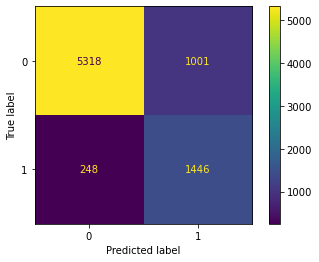

In [152]:
plot_confusion_matrix(best_model_h1n1, X_test, y_test.h1n1_vaccine)
plt.title ='h1n1 vaccine confusion matrix'
plt.show();

In [73]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

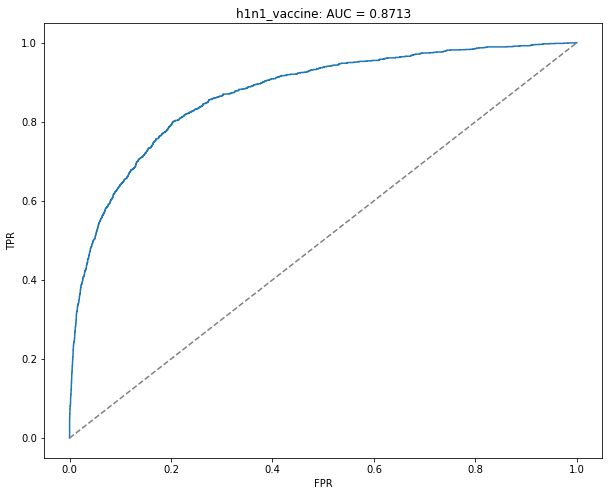

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'], 
    best_pred_h1n1, 
    'h1n1_vaccine',
    ax=ax
)

### Seasonal Vaccine

In [75]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [76]:
def objective2(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength':trial.suggest_int('random_strength', 1,10),
        'bagging_temperature':trial.suggest_int('bagging_temperature', 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree']),
        'od_type' : "Iter",
        'od_wait' : 100,
        'depth': trial.suggest_int('max_depth', 2,10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        'loss_function': 'Logloss',
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [80]:
sampler = optuna.samplers.TPESampler(seed=68)
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2022-01-26 22:11:12,181] A new study created in memory with name: no-name-f14dc09b-1739-4471-a7a0-84026ef19b25
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/5]

bestTest = 0.4789440281
bestIteration = 169

Training on fold [1/5]

bestTest = 0.4682585941
bestIteration = 193

Training on fold [2/5]

bestTest = 0.4703996968
bestIteration = 156

Training on fold [3/5]

bestTest = 0.4556369312
bestIteration = 180

Training on fold [4/5]


[I 2022-01-26 22:11:58,761] Trial 0 finished with value: 0.8593868165076832 and parameters: {'iterations': 1500, 'learning_rate': 0.08961999953042239, 'random_strength': 9, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0011812125446097113, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8593868165076832.



bestTest = 0.4692511473
bestIteration = 170

Training on fold [0/5]

bestTest = 0.4770890344
bestIteration = 121

Training on fold [1/5]

bestTest = 0.465842965
bestIteration = 141

Training on fold [2/5]

bestTest = 0.4684124025
bestIteration = 80

Training on fold [3/5]

bestTest = 0.4579701636
bestIteration = 113

Training on fold [4/5]


[I 2022-01-26 22:12:01,561] Trial 1 finished with value: 0.860345874151206 and parameters: {'iterations': 1000, 'learning_rate': 0.2957047309441607, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.001354720669824658, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.860345874151206.



bestTest = 0.4662472659
bestIteration = 117

Training on fold [0/5]

bestTest = 0.4754388824
bestIteration = 351

Training on fold [1/5]

bestTest = 0.4683393546
bestIteration = 216

Training on fold [2/5]

bestTest = 0.467979347
bestIteration = 179

Training on fold [3/5]

bestTest = 0.4586970532
bestIteration = 250

Training on fold [4/5]


[I 2022-01-26 22:12:07,220] Trial 2 finished with value: 0.8606202389517286 and parameters: {'iterations': 1200, 'learning_rate': 0.1371525795360902, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.0048185425547954824, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8606202389517286.



bestTest = 0.4663679471
bestIteration = 281

Training on fold [0/5]

bestTest = 0.4948629497
bestIteration = 196

Training on fold [1/5]

bestTest = 0.4815324874
bestIteration = 216

Training on fold [2/5]

bestTest = 0.4825471884
bestIteration = 235

Training on fold [3/5]

bestTest = 0.4826897365
bestIteration = 174

Training on fold [4/5]


[I 2022-01-26 22:13:18,896] Trial 3 finished with value: 0.849942102617159 and parameters: {'iterations': 300, 'learning_rate': 0.026623822549052163, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 1.9008463722440555e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8606202389517286.



bestTest = 0.4867178236
bestIteration = 156

Training on fold [0/5]

bestTest = 0.4846899939
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4763366383
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4752090352
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4686157921
bestIteration = 999

Training on fold [4/5]


[I 2022-01-26 22:13:50,553] Trial 4 finished with value: 0.857837525117682 and parameters: {'iterations': 1000, 'learning_rate': 0.007101034052723374, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.005827202489296445, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8606202389517286.



bestTest = 0.4746604878
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4791833139
bestIteration = 81

Training on fold [1/5]

bestTest = 0.466493637
bestIteration = 128

Training on fold [2/5]

bestTest = 0.4732777386
bestIteration = 60

Training on fold [3/5]

bestTest = 0.4635296818
bestIteration = 55

Training on fold [4/5]


[I 2022-01-26 22:13:52,531] Trial 5 finished with value: 0.8587409941282133 and parameters: {'iterations': 1500, 'learning_rate': 0.2964430813582234, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 1.7622702261668875e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8606202389517286.



bestTest = 0.4674640727
bestIteration = 96

Training on fold [0/5]

bestTest = 0.4756116044
bestIteration = 66

Training on fold [1/5]

bestTest = 0.4644011601
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4648154748
bestIteration = 72

Training on fold [3/5]

bestTest = 0.448930821
bestIteration = 110

Training on fold [4/5]


[I 2022-01-26 22:14:16,765] Trial 6 finished with value: 0.8618040497560353 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 23.41661191676168, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8618040497560353.



bestTest = 0.4666766128
bestIteration = 70

Training on fold [0/5]

bestTest = 0.5268494835
bestIteration = 19

Training on fold [1/5]

bestTest = 0.521511019
bestIteration = 18

Training on fold [2/5]

bestTest = 0.5116342999
bestIteration = 20

Training on fold [3/5]

bestTest = 0.507380678
bestIteration = 21

Training on fold [4/5]


[I 2022-01-26 22:14:19,383] Trial 7 finished with value: 0.8317156841547483 and parameters: {'iterations': 1500, 'learning_rate': 0.1253699635699981, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 2.8307160689696775e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8618040497560353.



bestTest = 0.5069147998
bestIteration = 20

Training on fold [0/5]

bestTest = 0.4897138303
bestIteration = 241

Training on fold [1/5]

bestTest = 0.4846576375
bestIteration = 231

Training on fold [2/5]

bestTest = 0.4711461927
bestIteration = 284

Training on fold [3/5]

bestTest = 0.4679942307
bestIteration = 296

Training on fold [4/5]


[I 2022-01-26 22:14:44,893] Trial 8 finished with value: 0.8537652773494571 and parameters: {'iterations': 1000, 'learning_rate': 0.00957473821190967, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0003332900472045444, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8618040497560353.



bestTest = 0.4778209095
bestIteration = 315

Training on fold [0/5]

bestTest = 0.5156778663
bestIteration = 8

Training on fold [1/5]

bestTest = 0.5251662295
bestIteration = 6

Training on fold [2/5]

bestTest = 0.5104501024
bestIteration = 7

Training on fold [3/5]

bestTest = 0.5055155111
bestIteration = 8

Training on fold [4/5]


[I 2022-01-26 22:14:46,647] Trial 9 finished with value: 0.8318933261145813 and parameters: {'iterations': 1000, 'learning_rate': 0.2301364835144914, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0013398579507442577, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8618040497560353.



bestTest = 0.5191401504
bestIteration = 7

Training on fold [0/5]

bestTest = 0.474127904
bestIteration = 150

Training on fold [1/5]

bestTest = 0.4637253015
bestIteration = 100

Training on fold [2/5]

bestTest = 0.4641810146
bestIteration = 119

Training on fold [3/5]

bestTest = 0.452585378
bestIteration = 113

Training on fold [4/5]


[I 2022-01-26 22:15:05,144] Trial 10 finished with value: 0.862359108942251 and parameters: {'iterations': 300, 'learning_rate': 0.21210578031115196, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 67.55513953843523, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4658360021
bestIteration = 88

Training on fold [0/5]

bestTest = 0.4734393004
bestIteration = 124

Training on fold [1/5]

bestTest = 0.4635596636
bestIteration = 116

Training on fold [2/5]

bestTest = 0.4644007712
bestIteration = 93

Training on fold [3/5]

bestTest = 0.4554069726
bestIteration = 92

Training on fold [4/5]


[I 2022-01-26 22:15:22,396] Trial 11 finished with value: 0.8622109059136738 and parameters: {'iterations': 300, 'learning_rate': 0.21179272225527906, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 34.56103765349822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4646046968
bestIteration = 88

Training on fold [0/5]

bestTest = 0.4724145308
bestIteration = 152

Training on fold [1/5]

bestTest = 0.4662352134
bestIteration = 98

Training on fold [2/5]

bestTest = 0.4631763699
bestIteration = 120

Training on fold [3/5]

bestTest = 0.4523173227
bestIteration = 121

Training on fold [4/5]


[I 2022-01-26 22:15:42,494] Trial 12 finished with value: 0.8623405767694325 and parameters: {'iterations': 300, 'learning_rate': 0.21371183387618528, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 95.0310408809215, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4651785343
bestIteration = 126

Training on fold [0/5]

bestTest = 0.4736496533
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4621568561
bestIteration = 121

Training on fold [2/5]

bestTest = 0.4645777223
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4517520926
bestIteration = 147

Training on fold [4/5]


[I 2022-01-26 22:16:00,581] Trial 13 finished with value: 0.8623110694167042 and parameters: {'iterations': 500, 'learning_rate': 0.1836821261830615, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.8236334555490133, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4656831528
bestIteration = 106

Training on fold [0/5]

bestTest = 0.4759603051
bestIteration = 136

Training on fold [1/5]

bestTest = 0.4648820969
bestIteration = 128

Training on fold [2/5]

bestTest = 0.4647245673
bestIteration = 104

Training on fold [3/5]

bestTest = 0.4530818531
bestIteration = 140

Training on fold [4/5]


[I 2022-01-26 22:16:19,464] Trial 14 finished with value: 0.8611865259697262 and parameters: {'iterations': 300, 'learning_rate': 0.18241430488443391, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.5135319808098414, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4684204666
bestIteration = 111

Training on fold [0/5]

bestTest = 0.4799253078
bestIteration = 36

Training on fold [1/5]

bestTest = 0.4755874449
bestIteration = 40

Training on fold [2/5]

bestTest = 0.4730591093
bestIteration = 46

Training on fold [3/5]

bestTest = 0.462039807
bestIteration = 48

Training on fold [4/5]


[I 2022-01-26 22:16:40,081] Trial 15 finished with value: 0.8569542147767614 and parameters: {'iterations': 300, 'learning_rate': 0.2549106738246301, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.8549315771643822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4682033068
bestIteration = 49

Training on fold [0/5]

bestTest = 0.4737545929
bestIteration = 124

Training on fold [1/5]

bestTest = 0.4675977573
bestIteration = 100

Training on fold [2/5]

bestTest = 0.4645242261
bestIteration = 114

Training on fold [3/5]

bestTest = 0.4526097288
bestIteration = 103

Training on fold [4/5]


[I 2022-01-26 22:17:03,730] Trial 16 finished with value: 0.8619107591073064 and parameters: {'iterations': 1200, 'learning_rate': 0.17311448365052856, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 64.67976006485286, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4649549376
bestIteration = 105

Training on fold [0/5]

bestTest = 0.4752486402
bestIteration = 96

Training on fold [1/5]

bestTest = 0.4664943218
bestIteration = 102

Training on fold [2/5]

bestTest = 0.462831608
bestIteration = 117

Training on fold [3/5]

bestTest = 0.4554305135
bestIteration = 125

Training on fold [4/5]


[I 2022-01-26 22:17:16,205] Trial 17 finished with value: 0.861413743262799 and parameters: {'iterations': 500, 'learning_rate': 0.255740718764043, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.06363366937413929, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4658359213
bestIteration = 84

Training on fold [0/5]

bestTest = 0.4907250282
bestIteration = 66

Training on fold [1/5]

bestTest = 0.4854224609
bestIteration = 58

Training on fold [2/5]

bestTest = 0.4781286915
bestIteration = 52

Training on fold [3/5]

bestTest = 0.4779452799
bestIteration = 68

Training on fold [4/5]


[I 2022-01-26 22:17:19,657] Trial 18 finished with value: 0.8496512072955854 and parameters: {'iterations': 300, 'learning_rate': 0.08253977991457023, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.8479737297402608e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4863535705
bestIteration = 54

Training on fold [0/5]

bestTest = 0.473859996
bestIteration = 63

Training on fold [1/5]

bestTest = 0.4648689527
bestIteration = 59

Training on fold [2/5]

bestTest = 0.4635062108
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4545072142
bestIteration = 77

Training on fold [4/5]


[I 2022-01-26 22:17:36,947] Trial 19 finished with value: 0.8619257651561592 and parameters: {'iterations': 300, 'learning_rate': 0.2564310773921398, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 6.086419077213827, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4623460353
bestIteration = 66

Training on fold [0/5]

bestTest = 0.474365839
bestIteration = 134

Training on fold [1/5]

bestTest = 0.4622676553
bestIteration = 196

Training on fold [2/5]

bestTest = 0.4665139645
bestIteration = 93

Training on fold [3/5]

bestTest = 0.45527227
bestIteration = 126

Training on fold [4/5]


[I 2022-01-26 22:17:54,648] Trial 20 finished with value: 0.8621509160231033 and parameters: {'iterations': 300, 'learning_rate': 0.15754469939693322, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.11952211033300277, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.862359108942251.



bestTest = 0.4654623359
bestIteration = 161

Training on fold [0/5]

bestTest = 0.4752490407
bestIteration = 137

Training on fold [1/5]

bestTest = 0.4641212994
bestIteration = 123

Training on fold [2/5]

bestTest = 0.4615573293
bestIteration = 119

Training on fold [3/5]

bestTest = 0.4515070026
bestIteration = 128

Training on fold [4/5]


[I 2022-01-26 22:18:15,225] Trial 21 finished with value: 0.8625371458350231 and parameters: {'iterations': 500, 'learning_rate': 0.19633856469603955, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 1.9861187822429698, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4652675697
bestIteration = 134

Training on fold [0/5]

bestTest = 0.4722083514
bestIteration = 80

Training on fold [1/5]

bestTest = 0.46381913
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4639542684
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4520840554
bestIteration = 88

Training on fold [4/5]


[I 2022-01-26 22:18:35,059] Trial 22 finished with value: 0.8623758963845708 and parameters: {'iterations': 500, 'learning_rate': 0.20394358387568873, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 4.238956285476524, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4671527284
bestIteration = 75

Training on fold [0/5]

bestTest = 0.4741395873
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4643522559
bestIteration = 89

Training on fold [2/5]

bestTest = 0.4643941229
bestIteration = 70

Training on fold [3/5]

bestTest = 0.4495901406
bestIteration = 127

Training on fold [4/5]


[I 2022-01-26 22:18:56,359] Trial 23 finished with value: 0.8623385488038722 and parameters: {'iterations': 500, 'learning_rate': 0.19576770120795792, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 5.32039186310088, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4653729189
bestIteration = 79

Training on fold [0/5]

bestTest = 0.4750487594
bestIteration = 95

Training on fold [1/5]

bestTest = 0.4680362979
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4627039921
bestIteration = 109

Training on fold [3/5]

bestTest = 0.4498001325
bestIteration = 118

Training on fold [4/5]


[I 2022-01-26 22:19:33,637] Trial 24 finished with value: 0.8619302258129098 and parameters: {'iterations': 500, 'learning_rate': 0.15279097276120915, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 4.322237703721421, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4640874108
bestIteration = 97

Training on fold [0/5]

bestTest = 0.4766597801
bestIteration = 213

Training on fold [1/5]

bestTest = 0.4658741239
bestIteration = 201

Training on fold [2/5]

bestTest = 0.4654708403
bestIteration = 156

Training on fold [3/5]

bestTest = 0.4544610975
bestIteration = 217

Training on fold [4/5]


[I 2022-01-26 22:19:57,105] Trial 25 finished with value: 0.8615450751588153 and parameters: {'iterations': 500, 'learning_rate': 0.11082249099846167, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.06431677615949156, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4662533325
bestIteration = 221

Training on fold [0/5]

bestTest = 0.4769776443
bestIteration = 51

Training on fold [1/5]

bestTest = 0.4644847636
bestIteration = 60

Training on fold [2/5]

bestTest = 0.4634868635
bestIteration = 74

Training on fold [3/5]

bestTest = 0.4515559099
bestIteration = 80

Training on fold [4/5]


[I 2022-01-26 22:20:15,057] Trial 26 finished with value: 0.861607261486092 and parameters: {'iterations': 500, 'learning_rate': 0.24808940056373904, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 4.3413749386691265, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4657990262
bestIteration = 100

Training on fold [0/5]

bestTest = 0.4850032684
bestIteration = 33

Training on fold [1/5]

bestTest = 0.4743926682
bestIteration = 61

Training on fold [2/5]

bestTest = 0.4686152357
bestIteration = 53

Training on fold [3/5]

bestTest = 0.456894532
bestIteration = 71

Training on fold [4/5]


[I 2022-01-26 22:20:36,298] Trial 27 finished with value: 0.8574828036972983 and parameters: {'iterations': 500, 'learning_rate': 0.20105741689107434, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.18315139256737686, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4722961422
bestIteration = 50

Training on fold [0/5]

bestTest = 0.4764847312
bestIteration = 115

Training on fold [1/5]

bestTest = 0.4677820207
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4644991156
bestIteration = 117

Training on fold [3/5]

bestTest = 0.4547448802
bestIteration = 136

Training on fold [4/5]


[I 2022-01-26 22:20:51,158] Trial 28 finished with value: 0.8612570628464619 and parameters: {'iterations': 500, 'learning_rate': 0.1652384257078016, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 1.0595003544247859e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4659474265
bestIteration = 130

Training on fold [0/5]

bestTest = 0.4835328235
bestIteration = 93

Training on fold [1/5]

bestTest = 0.4693596781
bestIteration = 115

Training on fold [2/5]

bestTest = 0.4672650349
bestIteration = 149

Training on fold [3/5]

bestTest = 0.4581679633
bestIteration = 146

Training on fold [4/5]


[I 2022-01-26 22:21:34,921] Trial 29 finished with value: 0.8587868425602239 and parameters: {'iterations': 1200, 'learning_rate': 0.07792970912774126, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.013263638814600636, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4716293234
bestIteration = 116

Training on fold [0/5]

bestTest = 0.4757807796
bestIteration = 66

Training on fold [1/5]

bestTest = 0.466152972
bestIteration = 81

Training on fold [2/5]

bestTest = 0.4641652045
bestIteration = 90

Training on fold [3/5]

bestTest = 0.4528152496
bestIteration = 92

Training on fold [4/5]


[I 2022-01-26 22:21:37,896] Trial 30 finished with value: 0.8614133058187605 and parameters: {'iterations': 1500, 'learning_rate': 0.23047588307538514, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 15.191284956146768, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4657784881
bestIteration = 66

Training on fold [0/5]

bestTest = 0.4748213036
bestIteration = 112

Training on fold [1/5]

bestTest = 0.4637492781
bestIteration = 129

Training on fold [2/5]

bestTest = 0.4623764658
bestIteration = 108

Training on fold [3/5]

bestTest = 0.4529385209
bestIteration = 129

Training on fold [4/5]


[I 2022-01-26 22:21:57,475] Trial 31 finished with value: 0.8624615143035902 and parameters: {'iterations': 500, 'learning_rate': 0.21104791284635674, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 75.21039098761982, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.464905422
bestIteration = 134

Training on fold [0/5]

bestTest = 0.4748402231
bestIteration = 96

Training on fold [1/5]

bestTest = 0.4634418873
bestIteration = 119

Training on fold [2/5]

bestTest = 0.4633786926
bestIteration = 95

Training on fold [3/5]

bestTest = 0.4530697379
bestIteration = 113

Training on fold [4/5]


[I 2022-01-26 22:22:13,774] Trial 32 finished with value: 0.8618352280373831 and parameters: {'iterations': 500, 'learning_rate': 0.19420818181589747, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 1.1968989291606147, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4683583332
bestIteration = 81

Training on fold [0/5]

bestTest = 0.4779616974
bestIteration = 55

Training on fold [1/5]

bestTest = 0.4666361537
bestIteration = 52

Training on fold [2/5]

bestTest = 0.4659810894
bestIteration = 86

Training on fold [3/5]

bestTest = 0.4512103338
bestIteration = 86

Training on fold [4/5]


[I 2022-01-26 22:22:33,580] Trial 33 finished with value: 0.861581900684914 and parameters: {'iterations': 500, 'learning_rate': 0.2759459923287105, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 13.31281082870404, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4609970969
bestIteration = 92

Training on fold [0/5]

bestTest = 0.4757105838
bestIteration = 89

Training on fold [1/5]

bestTest = 0.4655667557
bestIteration = 109

Training on fold [2/5]

bestTest = 0.4636385011
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4504914379
bestIteration = 158

Training on fold [4/5]


[I 2022-01-26 22:22:51,680] Trial 34 finished with value: 0.8624224371585782 and parameters: {'iterations': 500, 'learning_rate': 0.23581295355775805, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 95.09855203161959, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4642677652
bestIteration = 117

Training on fold [0/5]

bestTest = 0.4784280392
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4680652845
bestIteration = 106

Training on fold [2/5]

bestTest = 0.4692305107
bestIteration = 75

Training on fold [3/5]

bestTest = 0.4560746088
bestIteration = 155

Training on fold [4/5]


[I 2022-01-26 22:22:54,206] Trial 35 finished with value: 0.8599873531989196 and parameters: {'iterations': 500, 'learning_rate': 0.276856726154167, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 1.8568003643811335, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.4680490852
bestIteration = 95

Training on fold [0/5]

bestTest = 0.4758335499
bestIteration = 127

Training on fold [1/5]

bestTest = 0.465450378
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4662217553
bestIteration = 88

Training on fold [3/5]

bestTest = 0.4557942366
bestIteration = 116

Training on fold [4/5]


[I 2022-01-26 22:22:56,999] Trial 36 finished with value: 0.8610350869993244 and parameters: {'iterations': 500, 'learning_rate': 0.239897911469575, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.015729269447954015, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 21 with value: 0.8625371458350231.



bestTest = 0.466817057
bestIteration = 94

Training on fold [0/5]

bestTest = 0.4732604505
bestIteration = 149

Training on fold [1/5]

bestTest = 0.4658191321
bestIteration = 151

Training on fold [2/5]

bestTest = 0.4614390413
bestIteration = 137

Training on fold [3/5]

bestTest = 0.4498542531
bestIteration = 212

Training on fold [4/5]


[I 2022-01-26 22:23:33,203] Trial 37 finished with value: 0.8630247159638682 and parameters: {'iterations': 500, 'learning_rate': 0.13646409035069254, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 20.692141985760614, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 37 with value: 0.8630247159638682.



bestTest = 0.4623106214
bestIteration = 175

Training on fold [0/5]

bestTest = 0.4725109488
bestIteration = 131

Training on fold [1/5]

bestTest = 0.4616059512
bestIteration = 133

Training on fold [2/5]

bestTest = 0.4636587257
bestIteration = 96

Training on fold [3/5]

bestTest = 0.4518368722
bestIteration = 128

Training on fold [4/5]


[I 2022-01-26 22:24:04,067] Trial 38 finished with value: 0.8631716792116352 and parameters: {'iterations': 500, 'learning_rate': 0.13459058652284028, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 21.612879120617244, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 38 with value: 0.8631716792116352.



bestTest = 0.4643529935
bestIteration = 103

Training on fold [0/5]

bestTest = 0.4838475421
bestIteration = 78

Training on fold [1/5]

bestTest = 0.472451534
bestIteration = 55

Training on fold [2/5]

bestTest = 0.4769224893
bestIteration = 38

Training on fold [3/5]

bestTest = 0.4559423944
bestIteration = 72

Training on fold [4/5]


[I 2022-01-26 22:24:22,389] Trial 39 finished with value: 0.857154571502233 and parameters: {'iterations': 1200, 'learning_rate': 0.13771435206442664, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.00018184717357096306, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 38 with value: 0.8631716792116352.



bestTest = 0.4727389212
bestIteration = 65

Training on fold [0/5]

bestTest = 0.4740263513
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4626868072
bestIteration = 146

Training on fold [2/5]

bestTest = 0.4628949788
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4522808997
bestIteration = 113

Training on fold [4/5]


[I 2022-01-26 22:24:56,369] Trial 40 finished with value: 0.8628220023892869 and parameters: {'iterations': 1500, 'learning_rate': 0.10427514319116662, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 16.795134709223134, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 38 with value: 0.8631716792116352.



bestTest = 0.463967646
bestIteration = 173

Training on fold [0/5]

bestTest = 0.4725953915
bestIteration = 243

Training on fold [1/5]

bestTest = 0.4649207105
bestIteration = 204

Training on fold [2/5]

bestTest = 0.4618654034
bestIteration = 234

Training on fold [3/5]

bestTest = 0.4496385323
bestIteration = 269

Training on fold [4/5]


[I 2022-01-26 22:25:59,346] Trial 41 finished with value: 0.8634317044476256 and parameters: {'iterations': 1500, 'learning_rate': 0.05965219894190976, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 18.8047896890382, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4628543839
bestIteration = 297

Training on fold [0/5]

bestTest = 0.4743644856
bestIteration = 186

Training on fold [1/5]

bestTest = 0.4644729696
bestIteration = 212

Training on fold [2/5]

bestTest = 0.4634026586
bestIteration = 196

Training on fold [3/5]

bestTest = 0.4490740813
bestIteration = 329

Training on fold [4/5]


[I 2022-01-26 22:26:55,647] Trial 42 finished with value: 0.8630118439488559 and parameters: {'iterations': 1500, 'learning_rate': 0.060821120296359804, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 20.009304441456738, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4636198673
bestIteration = 201

Training on fold [0/5]

bestTest = 0.4739176528
bestIteration = 163

Training on fold [1/5]

bestTest = 0.4634630468
bestIteration = 255

Training on fold [2/5]

bestTest = 0.461332811
bestIteration = 187

Training on fold [3/5]

bestTest = 0.4497053642
bestIteration = 270

Training on fold [4/5]


[I 2022-01-26 22:27:53,973] Trial 43 finished with value: 0.8633710226658928 and parameters: {'iterations': 1500, 'learning_rate': 0.05880421006840924, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 18.845132807689296, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4639629724
bestIteration = 257

Training on fold [0/5]

bestTest = 0.472941223
bestIteration = 196

Training on fold [1/5]

bestTest = 0.462544954
bestIteration = 249

Training on fold [2/5]

bestTest = 0.4621003645
bestIteration = 177

Training on fold [3/5]

bestTest = 0.4526004215
bestIteration = 170

Training on fold [4/5]


[I 2022-01-26 22:29:03,994] Trial 44 finished with value: 0.8629465085177508 and parameters: {'iterations': 1500, 'learning_rate': 0.06149335611342682, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 25.86792055406844, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.465193223
bestIteration = 161

Training on fold [0/5]

bestTest = 0.4802425391
bestIteration = 142

Training on fold [1/5]

bestTest = 0.4648041128
bestIteration = 205

Training on fold [2/5]

bestTest = 0.4655802862
bestIteration = 177

Training on fold [3/5]

bestTest = 0.4572141967
bestIteration = 207

Training on fold [4/5]


[I 2022-01-26 22:30:26,935] Trial 45 finished with value: 0.8599694292060232 and parameters: {'iterations': 1500, 'learning_rate': 0.04594823140583779, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.26207994694957665, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4705964351
bestIteration = 167

Training on fold [0/5]

bestTest = 0.4729060104
bestIteration = 375

Training on fold [1/5]

bestTest = 0.4646033444
bestIteration = 340

Training on fold [2/5]

bestTest = 0.4614954697
bestIteration = 401

Training on fold [3/5]

bestTest = 0.4504062937
bestIteration = 431

Training on fold [4/5]


[I 2022-01-26 22:31:58,037] Trial 46 finished with value: 0.8631249173838296 and parameters: {'iterations': 1500, 'learning_rate': 0.03351026240031679, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 8.153980826375557, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4649265784
bestIteration = 304

Training on fold [0/5]

bestTest = 0.4741986662
bestIteration = 505

Training on fold [1/5]

bestTest = 0.4621495276
bestIteration = 547

Training on fold [2/5]

bestTest = 0.4617748714
bestIteration = 514

Training on fold [3/5]

bestTest = 0.4507308515
bestIteration = 531

Training on fold [4/5]


[I 2022-01-26 22:34:47,417] Trial 47 finished with value: 0.8631508283778698 and parameters: {'iterations': 1500, 'learning_rate': 0.02455783163003157, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 9.603328652198144, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4658259969
bestIteration = 442

Training on fold [0/5]

bestTest = 0.4781074837
bestIteration = 245

Training on fold [1/5]

bestTest = 0.469645306
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4644553116
bestIteration = 241

Training on fold [3/5]

bestTest = 0.4533957704
bestIteration = 305

Training on fold [4/5]


[I 2022-01-26 22:37:03,279] Trial 48 finished with value: 0.8603325603895644 and parameters: {'iterations': 1500, 'learning_rate': 0.023669076910498604, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0.463306045621743, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4695731351
bestIteration = 228

Training on fold [0/5]

bestTest = 0.4765396211
bestIteration = 262

Training on fold [1/5]

bestTest = 0.4646021056
bestIteration = 340

Training on fold [2/5]

bestTest = 0.4628467587
bestIteration = 262

Training on fold [3/5]

bestTest = 0.4513680435
bestIteration = 379

Training on fold [4/5]


[I 2022-01-26 22:38:51,379] Trial 49 finished with value: 0.8622774998524741 and parameters: {'iterations': 1500, 'learning_rate': 0.03541089943075911, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 2.247031059483696, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4662830354
bestIteration = 300

Training on fold [0/5]

bestTest = 0.4726188862
bestIteration = 1095

Training on fold [1/5]

bestTest = 0.4649965376
bestIteration = 803

Training on fold [2/5]

bestTest = 0.4612841009
bestIteration = 1017

Training on fold [3/5]

bestTest = 0.4512880479
bestIteration = 969

Training on fold [4/5]


[I 2022-01-26 22:42:48,750] Trial 50 finished with value: 0.8631432009017675 and parameters: {'iterations': 1500, 'learning_rate': 0.012350340084815094, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 8.559002993548935, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4659661627
bestIteration = 801

Training on fold [0/5]

bestTest = 0.4732658105
bestIteration = 1063

Training on fold [1/5]

bestTest = 0.464299195
bestIteration = 924

Training on fold [2/5]

bestTest = 0.4626607305
bestIteration = 884

Training on fold [3/5]

bestTest = 0.4502524215
bestIteration = 1263

Training on fold [4/5]


[I 2022-01-26 22:46:54,147] Trial 51 finished with value: 0.8631694605007132 and parameters: {'iterations': 1500, 'learning_rate': 0.012223406488668693, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 46.27286921231181, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4661969742
bestIteration = 795

Training on fold [0/5]

bestTest = 0.4738551737
bestIteration = 925

Training on fold [1/5]

bestTest = 0.4636417147
bestIteration = 1089

Training on fold [2/5]

bestTest = 0.4626195058
bestIteration = 1024

Training on fold [3/5]

bestTest = 0.4509436585
bestIteration = 1158

Training on fold [4/5]


[I 2022-01-26 22:52:55,535] Trial 52 finished with value: 0.8631524507598918 and parameters: {'iterations': 1500, 'learning_rate': 0.010153287665524511, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 39.14923720898998, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4643942945
bestIteration = 1237

Training on fold [0/5]

bestTest = 0.4819909331
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4739794196
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4704772257
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4633121086
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-26 23:02:42,586] Trial 53 finished with value: 0.8596382552529616 and parameters: {'iterations': 1500, 'learning_rate': 0.005807324007125608, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 46.743369469933555, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4730098307
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4746566184
bestIteration = 287

Training on fold [1/5]

bestTest = 0.4640466595
bestIteration = 262

Training on fold [2/5]

bestTest = 0.4622059393
bestIteration = 258

Training on fold [3/5]

bestTest = 0.4508533244
bestIteration = 289

Training on fold [4/5]


[I 2022-01-26 23:04:16,787] Trial 54 finished with value: 0.8630242434222936 and parameters: {'iterations': 1000, 'learning_rate': 0.047285118044536126, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 34.7710047087188, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4641446187
bestIteration = 290

Training on fold [0/5]

bestTest = 0.4791336688
bestIteration = 319

Training on fold [1/5]

bestTest = 0.471192411
bestIteration = 263

Training on fold [2/5]

bestTest = 0.4684764834
bestIteration = 266

Training on fold [3/5]

bestTest = 0.461738245
bestIteration = 262

Training on fold [4/5]


[I 2022-01-26 23:05:56,433] Trial 55 finished with value: 0.8589708967637607 and parameters: {'iterations': 1500, 'learning_rate': 0.019218733266616522, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 3.695034351082469e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4713298739
bestIteration = 323

Training on fold [0/5]

bestTest = 0.4869777698
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4785337648
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.475187145
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4700272103
bestIteration = 1499

Training on fold [4/5]


[I 2022-01-26 23:06:46,763] Trial 56 finished with value: 0.8570803675048853 and parameters: {'iterations': 1500, 'learning_rate': 0.0027132295444817506, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 98.69972028816197, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4768876361
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4754094405
bestIteration = 138

Training on fold [1/5]

bestTest = 0.4635470556
bestIteration = 198

Training on fold [2/5]

bestTest = 0.4628334592
bestIteration = 161

Training on fold [3/5]

bestTest = 0.4523105744
bestIteration = 189

Training on fold [4/5]


[I 2022-01-26 23:07:53,729] Trial 57 finished with value: 0.8618851650402093 and parameters: {'iterations': 1500, 'learning_rate': 0.06676064556003125, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.926947485481116, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4670194759
bestIteration = 172

Training on fold [0/5]

bestTest = 0.4748452719
bestIteration = 221

Training on fold [1/5]

bestTest = 0.4651398936
bestIteration = 183

Training on fold [2/5]

bestTest = 0.4619613668
bestIteration = 266

Training on fold [3/5]

bestTest = 0.4531781874
bestIteration = 288

Training on fold [4/5]


[I 2022-01-26 23:08:03,493] Trial 58 finished with value: 0.8623768966983828 and parameters: {'iterations': 1500, 'learning_rate': 0.04664548041352265, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.7804631380610895, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4640994244
bestIteration = 223

Training on fold [0/5]

bestTest = 0.4766915968
bestIteration = 300

Training on fold [1/5]

bestTest = 0.4635258245
bestIteration = 439

Training on fold [2/5]

bestTest = 0.4626116126
bestIteration = 369

Training on fold [3/5]

bestTest = 0.4504211418
bestIteration = 403

Training on fold [4/5]


[I 2022-01-26 23:10:47,096] Trial 59 finished with value: 0.8625684975772181 and parameters: {'iterations': 1000, 'learning_rate': 0.033175187803764425, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 42.55403754671906, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4649895568
bestIteration = 310

Training on fold [0/5]

bestTest = 0.4723609907
bestIteration = 174

Training on fold [1/5]

bestTest = 0.464270783
bestIteration = 176

Training on fold [2/5]

bestTest = 0.4619562595
bestIteration = 178

Training on fold [3/5]

bestTest = 0.4520109076
bestIteration = 181

Training on fold [4/5]


[I 2022-01-26 23:10:53,405] Trial 60 finished with value: 0.8631094808537336 and parameters: {'iterations': 1500, 'learning_rate': 0.09398205367250419, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 10.467021216682893, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8634317044476256.



bestTest = 0.4627195741
bestIteration = 139

Training on fold [0/5]

bestTest = 0.4724331303
bestIteration = 828

Training on fold [1/5]

bestTest = 0.4633807865
bestIteration = 782

Training on fold [2/5]

bestTest = 0.4622018326
bestIteration = 812

Training on fold [3/5]

bestTest = 0.4512579497
bestIteration = 759

Training on fold [4/5]


[I 2022-01-26 23:14:07,186] Trial 61 finished with value: 0.8634701377179363 and parameters: {'iterations': 1500, 'learning_rate': 0.016089782764488563, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 8.480090372656854, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 61 with value: 0.8634701377179363.



bestTest = 0.4636584727
bestIteration = 860

Training on fold [0/5]

bestTest = 0.4729669944
bestIteration = 809

Training on fold [1/5]

bestTest = 0.4643145828
bestIteration = 743

Training on fold [2/5]

bestTest = 0.4610620454
bestIteration = 764

Training on fold [3/5]

bestTest = 0.4505544868
bestIteration = 850

Training on fold [4/5]


[I 2022-01-26 23:17:13,646] Trial 62 finished with value: 0.8635427932966795 and parameters: {'iterations': 1500, 'learning_rate': 0.01691113956497472, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 37.498037039001254, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 62 with value: 0.8635427932966795.



bestTest = 0.4636960097
bestIteration = 814

Training on fold [0/5]

bestTest = 0.4727580526
bestIteration = 1341

Training on fold [1/5]

bestTest = 0.4645738889
bestIteration = 1115

Training on fold [2/5]

bestTest = 0.4619012949
bestIteration = 1275

Training on fold [3/5]

bestTest = 0.4523078353
bestIteration = 1166

Training on fold [4/5]


[I 2022-01-26 23:21:27,107] Trial 63 finished with value: 0.8631687971717781 and parameters: {'iterations': 1500, 'learning_rate': 0.011511681765191488, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 23.107750766298484, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 62 with value: 0.8635427932966795.



bestTest = 0.4648348496
bestIteration = 1281

Training on fold [0/5]

bestTest = 0.4735846978
bestIteration = 793

Training on fold [1/5]

bestTest = 0.4641863739
bestIteration = 838

Training on fold [2/5]

bestTest = 0.4623687983
bestIteration = 779

Training on fold [3/5]

bestTest = 0.4514833224
bestIteration = 956

Training on fold [4/5]


[I 2022-01-26 23:24:22,070] Trial 64 finished with value: 0.8631336665925083 and parameters: {'iterations': 1500, 'learning_rate': 0.016674703190226525, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 1.5558664402941265, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 62 with value: 0.8635427932966795.



bestTest = 0.4637711106
bestIteration = 907

Training on fold [0/5]

bestTest = 0.4734210787
bestIteration = 223

Training on fold [1/5]

bestTest = 0.4634829061
bestIteration = 347

Training on fold [2/5]

bestTest = 0.4619981432
bestIteration = 267

Training on fold [3/5]

bestTest = 0.4509488678
bestIteration = 377

Training on fold [4/5]


[I 2022-01-26 23:25:40,530] Trial 65 finished with value: 0.8628928288048122 and parameters: {'iterations': 1500, 'learning_rate': 0.043422186369585905, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 4.74753514218811, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 62 with value: 0.8635427932966795.



bestTest = 0.4653417535
bestIteration = 277

Training on fold [0/5]

bestTest = 0.4737304735
bestIteration = 198

Training on fold [1/5]

bestTest = 0.4634043506
bestIteration = 251

Training on fold [2/5]

bestTest = 0.461509707
bestIteration = 215

Training on fold [3/5]

bestTest = 0.4494803579
bestIteration = 331

Training on fold [4/5]


[I 2022-01-26 23:26:35,260] Trial 66 finished with value: 0.8633886041540745 and parameters: {'iterations': 1200, 'learning_rate': 0.07237927782245285, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 29.477029032940553, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 62 with value: 0.8635427932966795.



bestTest = 0.4642844672
bestIteration = 249

Training on fold [0/5]

bestTest = 0.4823033017
bestIteration = 84

Training on fold [1/5]

bestTest = 0.4681200716
bestIteration = 140

Training on fold [2/5]

bestTest = 0.4666410348
bestIteration = 118

Training on fold [3/5]

bestTest = 0.4577992918
bestIteration = 156

Training on fold [4/5]


[I 2022-01-26 23:27:10,571] Trial 67 finished with value: 0.8590896288558675 and parameters: {'iterations': 1200, 'learning_rate': 0.07388506137936722, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0004974683282225024, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 62 with value: 0.8635427932966795.



bestTest = 0.4698436073
bestIteration = 124

Training on fold [0/5]

bestTest = 0.4729455861
bestIteration = 272

Training on fold [1/5]

bestTest = 0.4637686158
bestIteration = 260

Training on fold [2/5]

bestTest = 0.4619247544
bestIteration = 255

Training on fold [3/5]

bestTest = 0.4502786288
bestIteration = 367

Training on fold [4/5]


[I 2022-01-26 23:27:19,828] Trial 68 finished with value: 0.8636683383353668 and parameters: {'iterations': 1200, 'learning_rate': 0.05489885151955885, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 52.50930657726749, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 68 with value: 0.8636683383353668.



bestTest = 0.4629337467
bestIteration = 329

Training on fold [0/5]

bestTest = 0.4739938933
bestIteration = 190

Training on fold [1/5]

bestTest = 0.4643374934
bestIteration = 177

Training on fold [2/5]

bestTest = 0.4599691673
bestIteration = 225

Training on fold [3/5]

bestTest = 0.4533357726
bestIteration = 201

Training on fold [4/5]


[I 2022-01-26 23:27:26,162] Trial 69 finished with value: 0.8630086613380319 and parameters: {'iterations': 1200, 'learning_rate': 0.0854525405726988, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 3.1238605600161913, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 68 with value: 0.8636683383353668.



bestTest = 0.4643642213
bestIteration = 184

Training on fold [0/5]

bestTest = 0.4740707902
bestIteration = 176

Training on fold [1/5]

bestTest = 0.4634289956
bestIteration = 177

Training on fold [2/5]

bestTest = 0.4615412736
bestIteration = 192

Training on fold [3/5]

bestTest = 0.4532193202
bestIteration = 151

Training on fold [4/5]


[I 2022-01-26 23:27:32,330] Trial 70 finished with value: 0.8628472175779967 and parameters: {'iterations': 1200, 'learning_rate': 0.09166258686412274, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 6.847479492663078, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 68 with value: 0.8636683383353668.



bestTest = 0.4643355485
bestIteration = 156

Training on fold [0/5]

bestTest = 0.4728089759
bestIteration = 179

Training on fold [1/5]

bestTest = 0.4637114457
bestIteration = 171

Training on fold [2/5]

bestTest = 0.4604153806
bestIteration = 231

Training on fold [3/5]

bestTest = 0.4515388192
bestIteration = 203

Training on fold [4/5]


[I 2022-01-26 23:27:40,838] Trial 71 finished with value: 0.8636956594092216 and parameters: {'iterations': 1200, 'learning_rate': 0.07167005678110938, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 41.99787491033593, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4617159312
bestIteration = 215

Training on fold [0/5]

bestTest = 0.4735219857
bestIteration = 255

Training on fold [1/5]

bestTest = 0.4648988743
bestIteration = 235

Training on fold [2/5]

bestTest = 0.4604600784
bestIteration = 357

Training on fold [3/5]

bestTest = 0.4512105175
bestIteration = 341

Training on fold [4/5]


[I 2022-01-26 23:27:51,061] Trial 72 finished with value: 0.8634413575213147 and parameters: {'iterations': 1200, 'learning_rate': 0.05590070230762444, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 60.64056576586881, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4628043206
bestIteration = 317

Training on fold [0/5]

bestTest = 0.47381482
bestIteration = 247

Training on fold [1/5]

bestTest = 0.4643363197
bestIteration = 275

Training on fold [2/5]

bestTest = 0.461301767
bestIteration = 294

Training on fold [3/5]

bestTest = 0.4503813612
bestIteration = 326

Training on fold [4/5]


[I 2022-01-26 23:28:00,810] Trial 73 finished with value: 0.8634399137904438 and parameters: {'iterations': 1200, 'learning_rate': 0.05831976187884211, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 95.26634347324793, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4630692273
bestIteration = 290

Training on fold [0/5]

bestTest = 0.4731409512
bestIteration = 280

Training on fold [1/5]

bestTest = 0.4641693886
bestIteration = 283

Training on fold [2/5]

bestTest = 0.4601224651
bestIteration = 332

Training on fold [3/5]

bestTest = 0.4517264382
bestIteration = 322

Training on fold [4/5]


[I 2022-01-26 23:28:11,160] Trial 74 finished with value: 0.8634941783574888 and parameters: {'iterations': 1200, 'learning_rate': 0.0545464462113165, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 67.47022523371626, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4632712865
bestIteration = 330

Training on fold [0/5]

bestTest = 0.4736697825
bestIteration = 332

Training on fold [1/5]

bestTest = 0.4638212025
bestIteration = 351

Training on fold [2/5]

bestTest = 0.460771801
bestIteration = 318

Training on fold [3/5]

bestTest = 0.4514467842
bestIteration = 441

Training on fold [4/5]


[I 2022-01-26 23:28:22,524] Trial 75 finished with value: 0.8634977368563742 and parameters: {'iterations': 1200, 'learning_rate': 0.05385189526305039, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 90.36012739731316, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4625291695
bestIteration = 356

Training on fold [0/5]

bestTest = 0.4740291535
bestIteration = 350

Training on fold [1/5]

bestTest = 0.4658407692
bestIteration = 293

Training on fold [2/5]

bestTest = 0.4617866368
bestIteration = 351

Training on fold [3/5]

bestTest = 0.4532081915
bestIteration = 330

Training on fold [4/5]


[I 2022-01-26 23:28:32,223] Trial 76 finished with value: 0.8629379503892505 and parameters: {'iterations': 1200, 'learning_rate': 0.05349894849614824, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 68.2714560706478, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4645308495
bestIteration = 318

Training on fold [0/5]

bestTest = 0.4723142799
bestIteration = 532

Training on fold [1/5]

bestTest = 0.4643663435
bestIteration = 363

Training on fold [2/5]

bestTest = 0.4609058966
bestIteration = 421

Training on fold [3/5]

bestTest = 0.4514205801
bestIteration = 535

Training on fold [4/5]


[I 2022-01-26 23:28:47,550] Trial 77 finished with value: 0.8636797473501602 and parameters: {'iterations': 1200, 'learning_rate': 0.035672981560652225, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 98.72300231840957, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4631688177
bestIteration = 515

Training on fold [0/5]

bestTest = 0.4730557705
bestIteration = 484

Training on fold [1/5]

bestTest = 0.4651225047
bestIteration = 404

Training on fold [2/5]

bestTest = 0.460913131
bestIteration = 475

Training on fold [3/5]

bestTest = 0.4505712426
bestIteration = 635

Training on fold [4/5]


[I 2022-01-26 23:29:03,179] Trial 78 finished with value: 0.8634838727752868 and parameters: {'iterations': 1200, 'learning_rate': 0.036706712652575794, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 50.11685666224256, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.4632313368
bestIteration = 440

Training on fold [0/5]

bestTest = 0.4744887035
bestIteration = 463

Training on fold [1/5]

bestTest = 0.4638996598
bestIteration = 597

Training on fold [2/5]

bestTest = 0.4604679426
bestIteration = 550

Training on fold [3/5]

bestTest = 0.4515154273
bestIteration = 590

Training on fold [4/5]


[I 2022-01-26 23:29:17,782] Trial 79 finished with value: 0.863279467248898 and parameters: {'iterations': 1200, 'learning_rate': 0.037812188530524, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 48.25870598663542, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8636956594092216.



bestTest = 0.465075983
bestIteration = 435

Training on fold [0/5]

bestTest = 0.4743434345
bestIteration = 482

Training on fold [1/5]

bestTest = 0.4627478796
bestIteration = 622

Training on fold [2/5]

bestTest = 0.4610276879
bestIteration = 608

Training on fold [3/5]

bestTest = 0.4505030634
bestIteration = 712

Training on fold [4/5]


[I 2022-01-26 23:29:35,669] Trial 80 finished with value: 0.863722383408763 and parameters: {'iterations': 1200, 'learning_rate': 0.029175274028570102, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 12.606735186514358, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4629222731
bestIteration = 557

Training on fold [0/5]

bestTest = 0.4735786407
bestIteration = 555

Training on fold [1/5]

bestTest = 0.4657533397
bestIteration = 493

Training on fold [2/5]

bestTest = 0.4614172069
bestIteration = 525

Training on fold [3/5]

bestTest = 0.4515442437
bestIteration = 589

Training on fold [4/5]


[I 2022-01-26 23:29:51,791] Trial 81 finished with value: 0.863466385837419 and parameters: {'iterations': 1200, 'learning_rate': 0.028841365172564266, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 12.169902381725143, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4624969281
bestIteration = 531

Training on fold [0/5]

bestTest = 0.4743172548
bestIteration = 382

Training on fold [1/5]

bestTest = 0.4643645811
bestIteration = 441

Training on fold [2/5]

bestTest = 0.4604655045
bestIteration = 455

Training on fold [3/5]

bestTest = 0.4517935194
bestIteration = 483

Training on fold [4/5]


[I 2022-01-26 23:30:05,228] Trial 82 finished with value: 0.863422228562305 and parameters: {'iterations': 1200, 'learning_rate': 0.0408388214837326, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 93.26292710427923, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4627229748
bestIteration = 413

Training on fold [0/5]

bestTest = 0.4737785053
bestIteration = 562

Training on fold [1/5]

bestTest = 0.4643391073
bestIteration = 530

Training on fold [2/5]

bestTest = 0.4601519755
bestIteration = 699

Training on fold [3/5]

bestTest = 0.4503274237
bestIteration = 699

Training on fold [4/5]


[I 2022-01-26 23:30:23,386] Trial 83 finished with value: 0.8635332344851825 and parameters: {'iterations': 1200, 'learning_rate': 0.027931888089246966, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 33.70314283389131, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.46409983
bestIteration = 519

Training on fold [0/5]

bestTest = 0.4749936683
bestIteration = 665

Training on fold [1/5]

bestTest = 0.4664229681
bestIteration = 545

Training on fold [2/5]

bestTest = 0.4619122221
bestIteration = 649

Training on fold [3/5]

bestTest = 0.4528438554
bestIteration = 771

Training on fold [4/5]


[I 2022-01-26 23:30:41,420] Trial 84 finished with value: 0.8627576185574009 and parameters: {'iterations': 1200, 'learning_rate': 0.02829919075588836, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 31.305525153915728, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4640216766
bestIteration = 687

Training on fold [0/5]

bestTest = 0.4749663831
bestIteration = 279

Training on fold [1/5]

bestTest = 0.4633839993
bestIteration = 416

Training on fold [2/5]

bestTest = 0.4615718853
bestIteration = 356

Training on fold [3/5]

bestTest = 0.4509635412
bestIteration = 433

Training on fold [4/5]


[I 2022-01-26 23:30:53,059] Trial 85 finished with value: 0.863246024130437 and parameters: {'iterations': 1200, 'learning_rate': 0.051093305295451655, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 56.10262439166201, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4631099289
bestIteration = 373

Training on fold [0/5]

bestTest = 0.4747010383
bestIteration = 236

Training on fold [1/5]

bestTest = 0.4635225509
bestIteration = 304

Training on fold [2/5]

bestTest = 0.4608699906
bestIteration = 315

Training on fold [3/5]

bestTest = 0.4518855438
bestIteration = 383

Training on fold [4/5]


[I 2022-01-26 23:31:01,930] Trial 86 finished with value: 0.8631614159405837 and parameters: {'iterations': 1200, 'learning_rate': 0.06603778781669059, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 13.584413473857404, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4640394163
bestIteration = 306

Training on fold [0/5]

bestTest = 0.474247921
bestIteration = 581

Training on fold [1/5]

bestTest = 0.4646149067
bestIteration = 635

Training on fold [2/5]

bestTest = 0.4604785099
bestIteration = 698

Training on fold [3/5]

bestTest = 0.4514250319
bestIteration = 755

Training on fold [4/5]


[I 2022-01-26 23:31:22,612] Trial 87 finished with value: 0.8632232313659787 and parameters: {'iterations': 1200, 'learning_rate': 0.025446394783463902, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 29.020553183916853, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.464034107
bestIteration = 609

Training on fold [0/5]

bestTest = 0.4779723935
bestIteration = 343

Training on fold [1/5]

bestTest = 0.4648764489
bestIteration = 354

Training on fold [2/5]

bestTest = 0.4670617296
bestIteration = 296

Training on fold [3/5]

bestTest = 0.4539019074
bestIteration = 419

Training on fold [4/5]


[I 2022-01-26 23:31:33,465] Trial 88 finished with value: 0.8616098682061551 and parameters: {'iterations': 1200, 'learning_rate': 0.03897754621328923, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 0.004664263694652506, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4652677065
bestIteration = 308

Training on fold [0/5]

bestTest = 0.4743195201
bestIteration = 210

Training on fold [1/5]

bestTest = 0.4648191145
bestIteration = 192

Training on fold [2/5]

bestTest = 0.4614085054
bestIteration = 217

Training on fold [3/5]

bestTest = 0.4501619989
bestIteration = 261

Training on fold [4/5]


[I 2022-01-26 23:31:40,340] Trial 89 finished with value: 0.8629380758925258 and parameters: {'iterations': 1200, 'learning_rate': 0.0791261538043228, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 4.552062198941075, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4645279541
bestIteration = 165

Training on fold [0/5]

bestTest = 0.4796069513
bestIteration = 158

Training on fold [1/5]

bestTest = 0.4662993354
bestIteration = 125

Training on fold [2/5]

bestTest = 0.4658260461
bestIteration = 115

Training on fold [3/5]

bestTest = 0.4568241344
bestIteration = 144

Training on fold [4/5]


[I 2022-01-26 23:31:44,062] Trial 90 finished with value: 0.860580646546917 and parameters: {'iterations': 1200, 'learning_rate': 0.11224235067287266, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 8.266044180046717e-05, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4679129865
bestIteration = 115

Training on fold [0/5]

bestTest = 0.4734028566
bestIteration = 748

Training on fold [1/5]

bestTest = 0.4648686038
bestIteration = 597

Training on fold [2/5]

bestTest = 0.4621654725
bestIteration = 605

Training on fold [3/5]

bestTest = 0.4514396717
bestIteration = 854

Training on fold [4/5]


[I 2022-01-26 23:32:05,306] Trial 91 finished with value: 0.8633521550777387 and parameters: {'iterations': 1200, 'learning_rate': 0.019666720942362815, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 8.011085252704715, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.863722383408763.



bestTest = 0.4634421633
bestIteration = 664

Training on fold [0/5]

bestTest = 0.4717858135
bestIteration = 468

Training on fold [1/5]

bestTest = 0.4632119936
bestIteration = 451

Training on fold [2/5]

bestTest = 0.4613852495
bestIteration = 470

Training on fold [3/5]

bestTest = 0.4504401282
bestIteration = 507

Training on fold [4/5]


[I 2022-01-26 23:32:21,152] Trial 92 finished with value: 0.8638205411796239 and parameters: {'iterations': 1200, 'learning_rate': 0.030743501184442096, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 56.112717992276465, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8638205411796239.



bestTest = 0.4639420021
bestIteration = 363

Training on fold [0/5]

bestTest = 0.5165920709
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5121080816
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.5066489453
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5063465596
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-26 23:32:57,247] Trial 93 finished with value: 0.8445469813653217 and parameters: {'iterations': 1200, 'learning_rate': 0.0012651965562862633, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 65.62463299921161, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8638205411796239.



bestTest = 0.5095065602
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4729618504
bestIteration = 374

Training on fold [1/5]

bestTest = 0.4636700378
bestIteration = 378

Training on fold [2/5]

bestTest = 0.4606983695
bestIteration = 430

Training on fold [3/5]

bestTest = 0.4514678969
bestIteration = 382

Training on fold [4/5]


[I 2022-01-26 23:33:10,547] Trial 94 finished with value: 0.8634997572385485 and parameters: {'iterations': 1200, 'learning_rate': 0.03309690803372834, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 14.705683146605264, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8638205411796239.



bestTest = 0.4639489434
bestIteration = 355

Training on fold [0/5]

bestTest = 0.4722201573
bestIteration = 243

Training on fold [1/5]

bestTest = 0.462344591
bestIteration = 318

Training on fold [2/5]

bestTest = 0.4612706507
bestIteration = 240

Training on fold [3/5]

bestTest = 0.4502066275
bestIteration = 330

Training on fold [4/5]


[I 2022-01-26 23:33:20,124] Trial 95 finished with value: 0.8638558954181164 and parameters: {'iterations': 1200, 'learning_rate': 0.05048040844522969, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 15.955644725744657, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.8638558954181164.



bestTest = 0.4634896807
bestIteration = 217

Training on fold [0/5]

bestTest = 0.4719881952
bestIteration = 504

Training on fold [1/5]

bestTest = 0.4625592637
bestIteration = 453

Training on fold [2/5]

bestTest = 0.4606017636
bestIteration = 478

Training on fold [3/5]

bestTest = 0.4504476929
bestIteration = 483

Training on fold [4/5]


[I 2022-01-26 23:33:36,206] Trial 96 finished with value: 0.8639637067584343 and parameters: {'iterations': 1200, 'learning_rate': 0.030023109561932198, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 16.880261102510804, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 96 with value: 0.8639637067584343.



bestTest = 0.4635138772
bestIteration = 404

Training on fold [0/5]

bestTest = 0.4740110577
bestIteration = 321

Training on fold [1/5]

bestTest = 0.463656599
bestIteration = 435

Training on fold [2/5]

bestTest = 0.4624046784
bestIteration = 334

Training on fold [3/5]

bestTest = 0.4489359659
bestIteration = 601

Training on fold [4/5]


[I 2022-01-26 23:33:50,266] Trial 97 finished with value: 0.8633721276650906 and parameters: {'iterations': 1200, 'learning_rate': 0.03207914180426274, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 15.342062129322034, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 96 with value: 0.8639637067584343.



bestTest = 0.464179373
bestIteration = 321

Training on fold [0/5]

bestTest = 0.4804758134
bestIteration = 276

Training on fold [1/5]

bestTest = 0.4701517922
bestIteration = 279

Training on fold [2/5]

bestTest = 0.4697305495
bestIteration = 259

Training on fold [3/5]

bestTest = 0.4582713918
bestIteration = 304

Training on fold [4/5]


[I 2022-01-26 23:33:59,936] Trial 98 finished with value: 0.8599174090734941 and parameters: {'iterations': 1200, 'learning_rate': 0.023031781860869217, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 1.1377461261612076e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 96 with value: 0.8639637067584343.



bestTest = 0.4680968112
bestIteration = 263

Training on fold [0/5]

bestTest = 0.4710868063
bestIteration = 298

Training on fold [1/5]

bestTest = 0.4630495838
bestIteration = 259

Training on fold [2/5]

bestTest = 0.4621068479
bestIteration = 237

Training on fold [3/5]

bestTest = 0.4520688283
bestIteration = 298

Training on fold [4/5]


[I 2022-01-26 23:34:09,517] Trial 99 finished with value: 0.8634975144732883 and parameters: {'iterations': 300, 'learning_rate': 0.048254492138275415, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 2.748290804103536, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 96 with value: 0.8639637067584343.



bestTest = 0.4636115535
bestIteration = 248



In [81]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items(): 
    print("    {}={},".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.8639637067584343
  Params: 
    iterations=1200,
    learning_rate=0.030023109561932198,
    random_strength=1,
    bagging_temperature=9,
    max_bin=8,
    grow_policy=SymmetricTree,
    max_depth=6,
    l2_leaf_reg=16.880261102510804,
    one_hot_max_size=500,
    auto_class_weights=Balanced,


In [82]:
params2 = {'iterations':1200,
         'learning_rate':0.030023109561932198,
         'cat_features': categorical_features_indices,
         'random_strength':1,
         'depth':6,
         'max_bin':8,
         'grow_policy':'SymmetricTree',
         'l2_leaf_reg':16.880261102510804,
         'bagging_temperature':9,
         'one_hot_max_size':500,
         'eval_metric':'AUC',
         'auto_class_weights':'Balanced',
         'verbose':False,
         }

In [83]:
best_model_seasonal = CatBoostClassifier(**params2)

In [84]:
best_model_seasonal.fit(X_train, y_train.seasonal_vaccine, eval_set=(X_test, y_test.seasonal_vaccine), use_best_model=True, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [85]:
best_pred_seasonal = best_model_seasonal.predict_proba(X_test)

In [86]:
best_pred_seasonal = best_pred_seasonal[:,1].reshape(-1,1)

In [129]:
roc_auc_score(y_test.seasonal_vaccine, best_pred_seasonal)

0.860779309512026

In [88]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **trial2.params)

In [89]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [90]:
predictions_se = final_model_se.predict_proba(X_test)

In [91]:
predictions_se = predictions_se[:,1].reshape(-1,1)

In [92]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8599424624638904

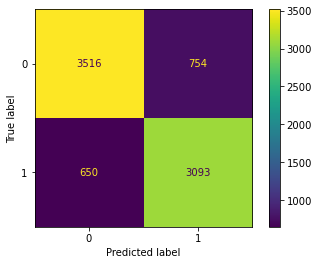

In [155]:
plot_confusion_matrix(best_model_seasonal, X_test, y_test.seasonal_vaccine)  
plt.show();

In [85]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

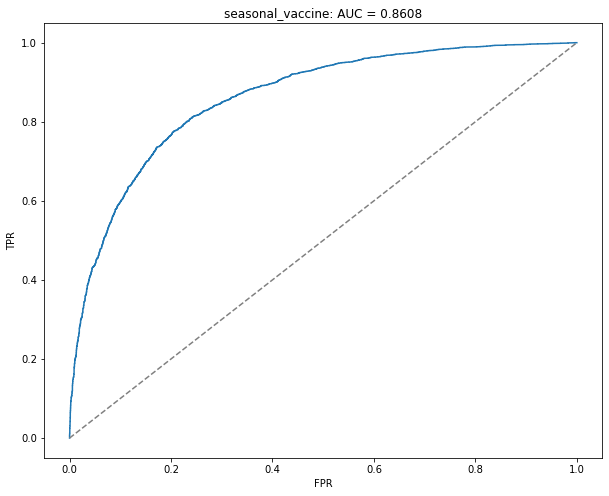

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    best_pred_seasonal, 
    'seasonal_vaccine',
    ax=ax
)

# Combined Score

In [94]:
roc_auc_score(y_test, np.hstack((best_pred_h1n1, best_pred_seasonal)))

0.8660641530411085

# Training on Full Dataset

In [16]:
test = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

### Seasonal Vaccine

In [99]:
best_model_seasonal.fit(train, labels.seasonal_vaccine)

In [100]:
final_se = best_model_seasonal.predict_proba(test)

In [101]:
final_se = final_se[:,1].reshape(-1,1)

### H1N1 Vaccine

In [95]:
best_model_h1n1.fit(train, labels.h1n1_vaccine)

In [110]:
final_h1 = best_model_h1n1.predict_proba(test)

In [111]:
final_h1 = final_h1[:,1].reshape(-1,1)

### For competition use

In [102]:
submission_df = pd.read_csv('data/submission_format.csv', index_col='respondent_id')

In [103]:
np.testing.assert_array_equal(test.index.values, submission_df.index.values)

In [104]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
...,...,...
53410,0.5,0.7
53411,0.5,0.7
53412,0.5,0.7


In [125]:
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se

submission_df.head(50)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.250532,0.290644
26708,0.114233,0.033589
26709,0.457484,0.751087
26710,0.824761,0.907961
26711,0.524087,0.520178
26712,0.936998,0.983097
26713,0.556574,0.634102
26714,0.467515,0.160198
26715,0.060049,0.116216


In [106]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'./{date}submssion_catboost_optuna.csv', index=True)

In [153]:
import pickle
filepath = 'data/models/Catboost_Optuna/h1n1/model_1.pickl'
pickle.dump(best_model_h1n1, open(filepath, 'wb'))

In [154]:
filepath = 'data/models/Catboost_Optuna/seasonal/model_1.pickl'
pickle.dump(best_model_seasonal, open(filepath, 'wb'))

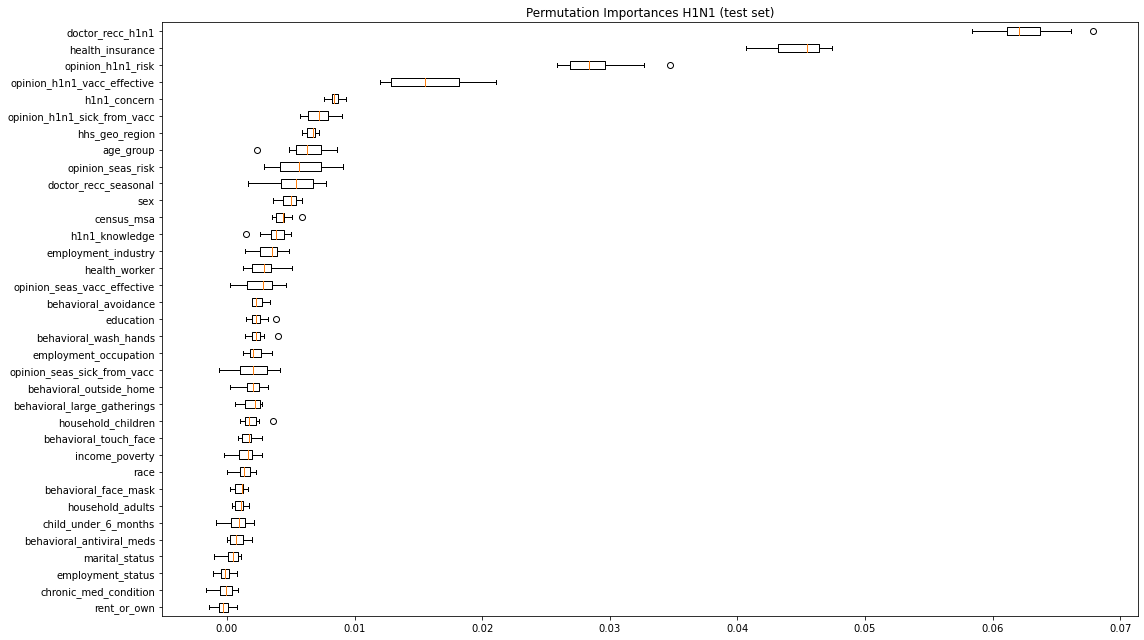

In [133]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    best_model_h1n1, X_test, y_test.h1n1_vaccine, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(16,9))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances H1N1 (test set)")
fig.tight_layout()
plt.show();

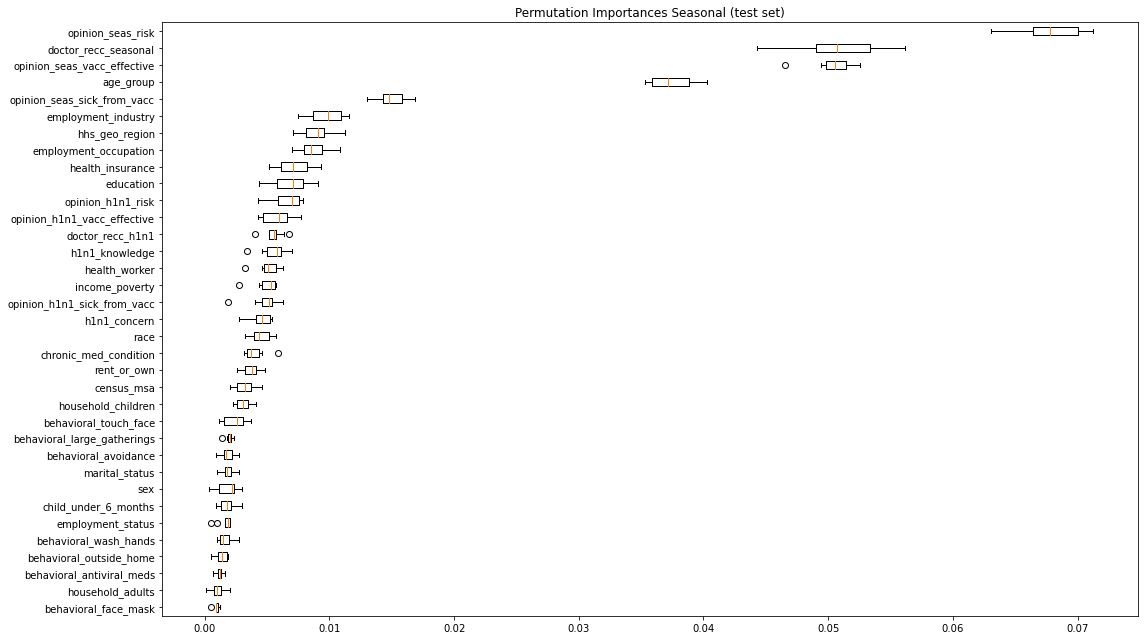

In [132]:
result = permutation_importance(
    best_model_seasonal, X_test, y_test.seasonal_vaccine, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(16,9))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances Seasonal (test set)")
fig.tight_layout()
plt.show();

In [137]:
final_h1

array([[0.25053203],
       [0.1142332 ],
       [0.45748366],
       ...,
       [0.35376134],
       [0.04398293],
       [0.83337339]])

In [138]:
y_test.h1n1_vaccine

respondent_id
2653     0
9506     0
23107    0
22648    0
25589    1
        ..
6273     0
9671     0
1301     0
21048    1
17388    0
Name: h1n1_vaccine, Length: 8013, dtype: int64

In [145]:
y_score=best_pred_h1n1
fpr, tpr,_ = roc_curve(y_test.h1n1_vaccine, y_score)
roc_auc = auc(fpr, tpr)
print('ROC AUC',roc_auc)

ROC AUC 0.871348996570191


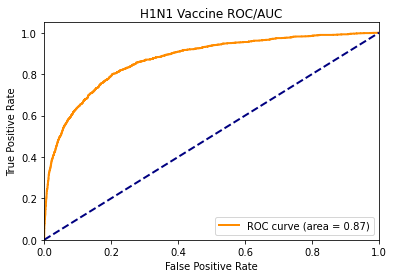

In [146]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("H1N1 Vaccine ROC/AUC")
plt.legend(loc="lower right")
plt.show()

In [147]:
y_score2=best_pred_seasonal
fpr, tpr,_ = roc_curve(y_test.seasonal_vaccine, y_score2)
roc_auc = auc(fpr, tpr)
print('ROC AUC',roc_auc)

ROC AUC 0.860779309512026


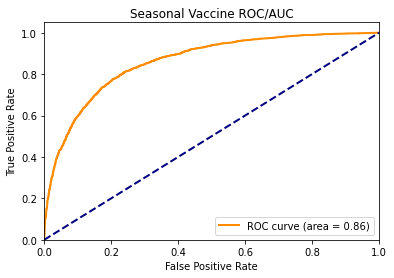

In [148]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Seasonal Vaccine ROC/AUC")
plt.legend(loc="lower right")
plt.show()

In [167]:
best_pred_h1n1

array([[0.15523741],
       [0.15743683],
       [0.12133563],
       ...,
       [0.33924607],
       [0.92281253],
       [0.78266811]])

In [172]:
from sklearn.metrics import classification_report
print(classification_report(y_test.h1n1_vaccine, best_h1n1))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      6319
           1       0.59      0.85      0.70      1694

    accuracy                           0.84      8013
   macro avg       0.77      0.85      0.80      8013
weighted avg       0.88      0.84      0.85      8013



In [170]:
best_h1n1 = best_model_h1n1.predict(X_test)

In [171]:
best_h1n1

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [173]:
best_seasonal = best_model_seasonal.predict(X_test)

In [174]:
print(classification_report(y_test.seasonal_vaccine, best_seasonal))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      4270
           1       0.80      0.83      0.82      3743

    accuracy                           0.82      8013
   macro avg       0.82      0.82      0.82      8013
weighted avg       0.83      0.82      0.82      8013

